#Fine-tuning Transformers (XLNET)




##Installing and Importing Libraries

In [0]:
USE_BUCKET = True #@param {type:"boolean"}

if USE_BUCKET:
  from google.colab import auth
  auth.authenticate_user()

In [0]:
!rm -r outputs_*

In [0]:
!pip install pytorch_transformers
!pip install tensorboardX
!gsutil cp gs://qatar_competition/multiutils.py ./
!gsutil cp gs://qatar_competition/modeling.py ./

     |████████████████████████████████| 184kB 3.4MB/s 
     |████████████████████████████████| 860kB 45.1MB/s 
     |████████████████████████████████| 1.0MB 34.1MB/s 
     |████████████████████████████████| 655kB 25.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.34-cp36-none-any.whl size=883992 sha256=5e76619abd8ed46994666c26bae9e5405b5d90d66b335cf2cb4c1c53fb7b0b61
  Stored in directory: /root/.cache/pip/wheels/07/b9/5b/8bd674c23e962fbff34420a9fa7a2c374d591ecadd5bc37684
  Created wheel for regex: filename=regex-2019.8.19-cp36-cp36m-linux_x86_64.whl size=609242 sha256=93811b13fc39138ed6e700d5fb50763f2dc77fadaf70892582020795a05c2317
  Stored in directory: /root/.cache/pip/wheels/90/04/07/b5010fb816721eb3d6dd64ed5cc8111ca23f97fdab8619b5be
Successfully built sacremoses regex
     |████████████████████████████████| 225kB 3.5MB/s 
Copying gs://qatar_competition/multiutils.py...
/ [1 files][ 15.1 KiB/ 15.1 KiB]                                                
Operation complete

In [0]:
!mkdir data_topic
!gsutil cp -r gs://qatar_competition/data_topic ./

Copying gs://qatar_competition/data_topic/dev.tsv...
Copying gs://qatar_competition/data_topic/train.tsv...
- [2 files][317.0 KiB/317.0 KiB]                                                
Operation completed over 2 objects/317.0 KiB.                                    


In [0]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

Writing setup.sh


In [0]:
!sh setup.sh

Cloning into 'apex'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 5433 (delta 1), reused 3 (delta 1), pack-reused 5422
Receiving objects: 100% (5433/5433), 13.32 MiB | 23.64 MiB/s, done.
Resolving deltas: 100% (3512/3512), done.
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:243: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-fp6o50jj
Created temporary directory: /tmp/pip-req-tracker-jokxgl1u
Created requirements tracker '/tmp/pip-req-tracker-jokxgl1u'
Created temporary directory: /tmp/pip-install-21cy9rgi
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-j7oedb73
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-jokxgl1u'
    Running setup.py (

In [0]:
from __future__ import absolute_import, division, print_function

import glob
import logging
import os
import random
import json

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import random
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm_notebook, trange
from tensorboardX import SummaryWriter

from modeling import BertForMultiLabelSequenceClassification, XLNetForMultiLabelSequenceClassification, RobertaForMultiLabelSequenceClassification, DistilBertForMultiLabelSequenceClassification

from pytorch_transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)

from pytorch_transformers import AdamW, WarmupLinearSchedule

from multiutils import (convert_examples_to_features,
                        output_modes, processors)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

##Initializing Arguments

In [0]:
args = {
    'data_dir': 'data_topic/',
    'model_type':  'xlnet',
    'model_name': 'xlnet-base-cased',
    'task_name': 'multi',
    'output_dir': 'outputs_xlnet/',
    'cache_dir': 'cache/',
    'do_train': True,
    'do_eval': True,
    'fp16': False,
    'fp16_opt_level': 'O1',
    'max_seq_length': 256,
    'output_mode': 'classification',
    'train_batch_size': 16,
    'eval_batch_size': 8,
    'gradient_accumulation_steps': 1,
    'num_train_epochs': 10,
    'weight_decay': 0,
    'learning_rate': 4e-5,
    'adam_epsilon': 1e-8,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 50,
    'evaluate_during_training': False,
    'save_steps': 20,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': False,
    'reprocess_input_data': True,
    'notes': 'Using Qatar Fake News dataset'
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
args

{'adam_epsilon': 1e-08,
 'cache_dir': 'cache/',
 'data_dir': 'data_topic/',
 'do_eval': True,
 'do_train': True,
 'eval_all_checkpoints': True,
 'eval_batch_size': 8,
 'evaluate_during_training': False,
 'fp16': False,
 'fp16_opt_level': 'O1',
 'gradient_accumulation_steps': 1,
 'learning_rate': 4e-05,
 'logging_steps': 50,
 'max_grad_norm': 1.0,
 'max_seq_length': 256,
 'model_name': 'xlnet-base-cased',
 'model_type': 'xlnet',
 'notes': 'Using Qatar Fake News dataset',
 'num_train_epochs': 10,
 'output_dir': 'outputs_xlnet/',
 'output_mode': 'classification',
 'overwrite_output_dir': False,
 'reprocess_input_data': True,
 'save_steps': 20,
 'task_name': 'multi',
 'train_batch_size': 16,
 'warmup_steps': 0,
 'weight_decay': 0}

In [0]:
with open('args.json', 'w') as f:
    json.dump(args, f)

In [0]:
if os.path.exists(args['output_dir']) and os.listdir(args['output_dir']) and args['do_train'] and not args['overwrite_output_dir']:
    raise ValueError("Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(args['output_dir']))

In [0]:
MODEL_CLASSES = {
    'bert': (BertConfig, BertForMultiLabelSequenceClassification, BertTokenizer),
    'xlnet': (XLNetConfig, XLNetForMultiLabelSequenceClassification, XLNetTokenizer),
    'xlm': (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    'roberta': (RobertaConfig, RobertaForMultiLabelSequenceClassification, RobertaTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES[args['model_type']]

##Importing Models

In [0]:
task = args['task_name']

if task in processors.keys() and task in output_modes.keys():
    processor = processors[task]()
    Label_list = processor.get_labels(6)
    num_labels = len(Label_list)
else:
    raise KeyError(f'{task} not found in processors or in output_modes. Please check utils.py.')

In [0]:
config = config_class.from_pretrained(args['model_name'], num_labels=num_labels, finetuning_task=args['task_name'])
tokenizer = tokenizer_class.from_pretrained(args['model_name'])

INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at /root/.cache/torch/pytorch_transformers/c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.ef1824921bc0786e97dc88d55eb17aabf18aac90f24bd34c0650529e7ba27d6f
INFO:pytorch_transformers.modeling_utils:Model config {
  "attn_type": "bi",
  "bi_data": false,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "ff_activation": "gelu",
  "finetuning_task": "multi",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "n_head": 12,
  "n_layer": 12,
  "n_token": 32000,
  "num_labels": 6,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj

In [0]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
model = model_class.from_pretrained(args['model_name'],config=config)

INFO:pytorch_transformers.modeling_utils:loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-pytorch_model.bin from cache at /root/.cache/torch/pytorch_transformers/24197ba0ce5dbfe23924431610704c88e2c0371afa49149360e4c823219ab474.7eac4fe898a021204e63c88c00ea68c60443c57f94b4bc3c02adbde6465745ac
INFO:pytorch_transformers.modeling_utils:Weights of XLNetForMultiLabelSequenceClassification not initialized from pretrained model: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
INFO:pytorch_transformers.modeling_utils:Weights from pretrained model not used in XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']


In [0]:
model.to(device);

##Defining Utility Functions

In [0]:
def load_and_cache_examples(task, tokenizer, mode="train"):
    processor = processors[task]()
    output_mode = args['output_mode']
    
    #mode = 'dev' if evaluate else 'train'
    cached_features_file = os.path.join(args['data_dir'], f"cached_{mode}_{args['model_name']}_{args['max_seq_length']}_{task}")
    
    if os.path.exists(cached_features_file) and not args['reprocess_input_data']:
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
               
    else:
        logger.info("Creating features from dataset file at %s", args['data_dir'])
        label_list = Label_list
        if mode=="train":
          examples=processor.get_train_examples(args['data_dir']);
        if mode=="dev":
          examples=processor.get_dev_examples(args['data_dir']);
        if mode=="predict":
          examples=processor.get_predict_examples(args['data_dir'])
        #examples = processor.get_dev_examples(args['data_dir']) if evaluate else processor.get_train_examples(args['data_dir'])
        
        if __name__ == "__main__":
            features = convert_examples_to_features(examples, label_list, args['max_seq_length'], tokenizer, output_mode,
                cls_token_at_end=bool(args['model_type'] in ['xlnet']),            # xlnet has a cls token at the end
                cls_token=tokenizer.cls_token,
                cls_token_segment_id=2 if args['model_type'] in ['xlnet'] else 0,
                sep_token=tokenizer.sep_token,
                sep_token_extra=bool(args['model_type'] in ['roberta']),           # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                pad_on_left=bool(args['model_type'] in ['xlnet']),                 # pad on the left for xlnet
                pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                pad_token_segment_id=4 if args['model_type'] in ['xlnet'] else 0)
        
        logger.info("Saving features into cached file %s", cached_features_file)
        torch.save(features, cached_features_file)
        
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    return dataset

In [0]:
def train(train_dataset, model, tokenizer):
    tb_writer = SummaryWriter()
    
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args['train_batch_size'])
    
    t_total = len(train_dataloader) // args['gradient_accumulation_steps'] * args['num_train_epochs']
    
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args['weight_decay']},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args['learning_rate'], eps=args['adam_epsilon'])
    scheduler = WarmupLinearSchedule(optimizer, warmup_steps=args['warmup_steps'], t_total=t_total)
    
    if args['fp16']:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args['fp16_opt_level'])
        
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args['num_train_epochs'])
    logger.info("  Total train batch size  = %d", args['train_batch_size'])
    logger.info("  Gradient Accumulation steps = %d", args['gradient_accumulation_steps'])
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(int(args['num_train_epochs']), desc="Epoch")
    
    for _ in train_iterator:
        epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
            print("\r%f" % loss, end='')

            if args['gradient_accumulation_steps'] > 1:
                loss = loss / args['gradient_accumulation_steps']

            if args['fp16']:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args['max_grad_norm'])
                
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), args['max_grad_norm'])

            tr_loss += loss.item()
            if (step + 1) % args['gradient_accumulation_steps'] == 0:
                scheduler.step()  # Update learning rate schedule
                optimizer.step()
                model.zero_grad()
                global_step += 1

                if args['logging_steps'] > 0 and global_step % args['logging_steps'] == 0:
                    # Log metrics
                    if args['evaluate_during_training']:  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar('eval_{}'.format(key), value, global_step)
                    tb_writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar('loss', (tr_loss - logging_loss)/args['logging_steps'], global_step)
                    logging_loss = tr_loss

                if args['save_steps'] > 0 and global_step % args['save_steps'] == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args['output_dir'], 'checkpoint-{}'.format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    logger.info("Saving model checkpoint to %s", output_dir)


    return global_step, tr_loss / global_step

In [0]:
from sklearn.metrics import mean_squared_error, matthews_corrcoef, multilabel_confusion_matrix ,classification_report,precision_recall_fscore_support,accuracy_score
from scipy.stats import pearsonr
import numpy as np

def get_mismatched(labels, preds):
    mismatched = labels != preds
    examples = processor.get_dev_examples(args['data_dir'])
    wrong = [i for (i, v) in zip(examples, mismatched) if v]
    
    return wrong

def get_eval_report(labels, preds):
    labels = np.argmax(labels,axis=1)
    #mcc = matthews_corrcoef(labels, preds)
    precision,recall,fscore,support = precision_recall_fscore_support(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)
    return {
        "precision": precision,
        "recall": recall,
        "fscore": fscore,
        "support": support,
        "accuracy": accuracy
    }, get_mismatched(labels, preds)

def compute_metrics(task_name, preds, labels):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def evaluate(model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args['output_dir']

    results = {}
    results_cr=[]
    EVAL_TASK = args['task_name']

    eval_dataset = load_and_cache_examples(EVAL_TASK, tokenizer, mode="dev")
    if not os.path.exists(eval_output_dir):
        os.makedirs(eval_output_dir)


    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args['eval_batch_size'])

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args['eval_batch_size'])
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    if args['output_mode'] == "classification":
        preds = np.argmax(preds, axis=1)
    elif args['output_mode'] == "regression":
        preds = np.squeeze(preds)
    result, wrong = compute_metrics(EVAL_TASK, preds, out_label_ids)
    print(classification_report(np.argmax(out_label_ids,axis=1),preds))
    
    results_cr.append(classification_report(np.argmax(out_label_ids,axis=1),preds))
    results.update(result)

    output_eval_file = os.path.join(eval_output_dir, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return results, wrong,results_cr

In [0]:
def predict(model, tokenizer, prefix=""):
  pred_output_dir = args['output_dir']
  
  results={}
  PRED_TASK = args['task_name']
  
  pred_dataset = load_and_cache_examples(PRED_TASK, tokenizer, mode='predict')
  if not os.path.exists(pred_output_dir):
    os.makedirs(pred_output_dir)
    
  
  pred_sampler = SequentialSampler(pred_dataset)
  pred_dataloader = DataLoader(pred_dataset, sampler=pred_sampler, batch_size=args['eval_batch_size'])
  
  # Eval!
  logger.info("***** Running prediction {} *****".format(prefix))
  logger.info("  Num examples = %d", len(pred_dataset))
  logger.info("  Batch size = %d", args['eval_batch_size'])
  
  preds = None
  for batch in pred_dataloader:
    with torch.no_grad():
      batch = tuple(t.to(device) for t in batch)
      inputs = {'input_ids': batch[0],'attention_mask': batch[1],'token_type_ids': batch[2],'labels': batch[3]}
      
      outputs = model(**inputs)
      _, logits = outputs[:2]
    if preds is None:
        preds = logits.detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)

  preds = np.argmax(preds, axis=1)
      
  return preds

##Training

In [0]:
if args['do_train']:
    train_dataset = load_and_cache_examples(task, tokenizer , mode="train")
    global_step, tr_loss = train(train_dataset, model, tokenizer)
    logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 384/384 [00:00<00:00, 892.71it/s]
INFO:__main__:Saving features into cached file data_topic/cached_train_xlnet-base-cased_256_multi
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 384
INFO:__main__:  Num Epochs = 10
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 240
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

0.738596

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0.329913

INFO:__main__:Saving model checkpoint to outputs_xlnet/checkpoint-20


0.303803

Epoch:  10%|█         | 1/10 [01:09<10:29, 69.98s/it]

0.118106

INFO:__main__:Saving model checkpoint to outputs_xlnet/checkpoint-40


0.130120

Epoch:  20%|██        | 2/10 [02:19<09:19, 69.97s/it]

0.109821

INFO:__main__:Saving model checkpoint to outputs_xlnet/checkpoint-60


0.038587

Epoch:  30%|███       | 3/10 [03:29<08:09, 69.96s/it]

0.066498

INFO:__main__:Saving model checkpoint to outputs_xlnet/checkpoint-80


0.042262

Epoch:  40%|████      | 4/10 [04:39<06:59, 69.89s/it]

0.021461

INFO:__main__:Saving model checkpoint to outputs_xlnet/checkpoint-100


0.016179

INFO:__main__:Saving model checkpoint to outputs_xlnet/checkpoint-120
Epoch:  50%|█████     | 5/10 [05:50<05:50, 70.20s/it]

0.014089

INFO:__main__:Saving model checkpoint to outputs_xlnet/checkpoint-140


0.013778

Epoch:  60%|██████    | 6/10 [07:00<04:40, 70.05s/it]

0.012021

INFO:__main__:Saving model checkpoint to outputs_xlnet/checkpoint-160


0.011984

Epoch:  70%|███████   | 7/10 [08:10<03:29, 69.99s/it]

0.011271

INFO:__main__:Saving model checkpoint to outputs_xlnet/checkpoint-180


0.011258

Epoch:  80%|████████  | 8/10 [09:19<02:19, 69.85s/it]

0.011650

INFO:__main__:Saving model checkpoint to outputs_xlnet/checkpoint-200


0.011113

Epoch:  90%|█████████ | 9/10 [10:28<01:09, 69.69s/it]

0.011135

INFO:__main__:Saving model checkpoint to outputs_xlnet/checkpoint-220


0.010386

INFO:__main__:Saving model checkpoint to outputs_xlnet/checkpoint-240
Epoch: 100%|██████████| 10/10 [11:39<00:00, 69.86s/it]
INFO:__main__: global_step = 240, average loss = 0.0813086234848015


Automatic pdb calling has been turned ON


In [0]:
label_map = {label : i for i, label in enumerate(Label_list)}

In [0]:
Label_list

['0', '1']

In [0]:
%pdb

Automatic pdb calling has been turned ON


In [0]:
import torch
torch.cuda.empty_cache()

In [0]:
if args['do_train']:
    if not os.path.exists(args['output_dir']):
            os.makedirs(args['output_dir'])
    logger.info("Saving model checkpoint to %s", args['output_dir'])
    
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(args['output_dir'])
    tokenizer.save_pretrained(args['output_dir'])
    torch.save(args, os.path.join(args['output_dir'], 'training_args.bin'))

INFO:__main__:Saving model checkpoint to outputs_bert/


##Evaluating

In [0]:
def get_num(file_name):
  s= file_name.split('-')[-1]
  if s=='outputs_xlnet':
    return 99999
  return int(s)

results = {}
results_cr = []
if args['do_eval']:
    checkpoints = [args['output_dir']]
    if args['eval_all_checkpoints']:
        checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
        logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
    logger.info("Evaluate the following checkpoints: %s", checkpoints)
    for checkpoint in sorted(checkpoints,reverse = False,key=get_num):
        print(checkpoint)
        global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
        model = model_class.from_pretrained(checkpoint)
        model.to(device)
        with torch.no_grad():
          result, wrong_preds,cr = evaluate(model, tokenizer, prefix=global_step)
          result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
          results.update(result)
          results_cr.append(cr)
        del model
        torch.cuda.empty_cache()

INFO:__main__:Evaluate the following checkpoints: ['outputs_xlnet/checkpoint-100', 'outputs_xlnet/checkpoint-120', 'outputs_xlnet/checkpoint-140', 'outputs_xlnet/checkpoint-160', 'outputs_xlnet/checkpoint-180', 'outputs_xlnet/checkpoint-20', 'outputs_xlnet/checkpoint-200', 'outputs_xlnet/checkpoint-220', 'outputs_xlnet/checkpoint-240', 'outputs_xlnet/checkpoint-40', 'outputs_xlnet/checkpoint-60', 'outputs_xlnet/checkpoint-80']


outputs_xlnet/checkpoint-20


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 337.88it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_xlnet-base-cased_256_multi
INFO:__main__:***** Running evaluation 20 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 20 *****
INFO:__main__:  accuracy = 0.6666666666666666
INFO:__main__:  fscore = 0.6461361737677528
INFO:__main__:  precision = 0.7232350982350982
INFO:__main__:  recall = 0.6666666666666666
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.43      0.38      0.40         8
           1       0.55      0.75      0.63         8
           2       1.00      0.25      0.40         8
           3       0.62      1.00      0.76         8
           4       1.00      0.88      0.93         8
           5       0.75      0.75      0.75         8

    accuracy                           0.67        48
   macro avg       0.72      0.67      0.65        48
weighted avg       0.72      0.67      0.65        48

outputs_xlnet/checkpoint-40


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 392.14it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_xlnet-base-cased_256_multi
INFO:__main__:***** Running evaluation 40 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 40 *****
INFO:__main__:  accuracy = 0.8125
INFO:__main__:  fscore = 0.789673828063921
INFO:__main__:  precision = 0.8164983164983165
INFO:__main__:  recall = 0.8125
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.67      0.25      0.36         8
           1       1.00      0.88      0.93         8
           2       0.78      0.88      0.82         8
           3       0.73      1.00      0.84         8
           4       1.00      0.88      0.93         8
           5       0.73      1.00      0.84         8

    accuracy                           0.81        48
   macro avg       0.82      0.81      0.79        48
weighted avg       0.82      0.81      0.79        48

outputs_xlnet/checkpoint-60


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 486.40it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_xlnet-base-cased_256_multi
INFO:__main__:***** Running evaluation 60 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 60 *****
INFO:__main__:  accuracy = 0.8958333333333334
INFO:__main__:  fscore = 0.8811051693404633
INFO:__main__:  precision = 0.925925925925926
INFO:__main__:  recall = 0.8958333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       1.00      1.00      1.00         8
           2       0.89      1.00      0.94         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       0.67      1.00      0.80         8

    accuracy                           0.90        48
   macro avg       0.93      0.90      0.88        48
weighted avg       0.93      0.90      0.88        48

outputs_xlnet/checkpoint-80


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 397.88it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_xlnet-base-cased_256_multi
INFO:__main__:***** Running evaluation 80 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 80 *****
INFO:__main__:  accuracy = 0.9166666666666666
INFO:__main__:  fscore = 0.911111111111111
INFO:__main__:  precision = 0.9444444444444445
INFO:__main__:  recall = 0.9166666666666666
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       0.67      1.00      0.80         8

    accuracy                           0.92        48
   macro avg       0.94      0.92      0.91        48
weighted avg       0.94      0.92      0.91        48

outputs_xlnet/checkpoint-100


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 403.96it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_xlnet-base-cased_256_multi
INFO:__main__:***** Running evaluation 100 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 100 *****
INFO:__main__:  accuracy = 0.8958333333333334
INFO:__main__:  fscore = 0.8901960784313725
INFO:__main__:  precision = 0.925925925925926
INFO:__main__:  recall = 0.8958333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.89      1.00      0.94         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      0.88      0.93         8
           5       0.67      1.00      0.80         8

    accuracy                           0.90        48
   macro avg       0.93      0.90      0.89        48
weighted avg       0.93      0.90      0.89        48

outputs_xlnet/checkpoint-120


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 407.81it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_xlnet-base-cased_256_multi
INFO:__main__:***** Running evaluation 120 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 120 *****
INFO:__main__:  accuracy = 0.875
INFO:__main__:  fscore = 0.8612794612794613
INFO:__main__:  precision = 0.9111111111111111
INFO:__main__:  recall = 0.875
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       1.00      1.00      1.00         8
           2       0.80      1.00      0.89         8
           3       1.00      1.00      1.00         8
           4       1.00      0.88      0.93         8
           5       0.67      1.00      0.80         8

    accuracy                           0.88        48
   macro avg       0.91      0.88      0.86        48
weighted avg       0.91      0.88      0.86        48

outputs_xlnet/checkpoint-140


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 407.94it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_xlnet-base-cased_256_multi
INFO:__main__:***** Running evaluation 140 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 140 *****
INFO:__main__:  accuracy = 0.875
INFO:__main__:  fscore = 0.8705379587732529
INFO:__main__:  precision = 0.8925925925925927
INFO:__main__:  recall = 0.875
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.89      1.00      0.94         8
           2       1.00      0.88      0.93         8
           3       1.00      1.00      1.00         8
           4       1.00      0.88      0.93         8
           5       0.67      1.00      0.80         8

    accuracy                           0.88        48
   macro avg       0.89      0.88      0.87        48
weighted avg       0.89      0.88      0.87        48

outputs_xlnet/checkpoint-160


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 417.53it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_xlnet-base-cased_256_multi
INFO:__main__:***** Running evaluation 160 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 160 *****
INFO:__main__:  accuracy = 0.8958333333333334
INFO:__main__:  fscore = 0.8901960784313725
INFO:__main__:  precision = 0.925925925925926
INFO:__main__:  recall = 0.8958333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.89      1.00      0.94         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      0.88      0.93         8
           5       0.67      1.00      0.80         8

    accuracy                           0.90        48
   macro avg       0.93      0.90      0.89        48
weighted avg       0.93      0.90      0.89        48

outputs_xlnet/checkpoint-180


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 388.89it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_xlnet-base-cased_256_multi
INFO:__main__:***** Running evaluation 180 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 180 *****
INFO:__main__:  accuracy = 0.8958333333333334
INFO:__main__:  fscore = 0.8901960784313725
INFO:__main__:  precision = 0.925925925925926
INFO:__main__:  recall = 0.8958333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.89      1.00      0.94         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      0.88      0.93         8
           5       0.67      1.00      0.80         8

    accuracy                           0.90        48
   macro avg       0.93      0.90      0.89        48
weighted avg       0.93      0.90      0.89        48

outputs_xlnet/checkpoint-200


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 415.73it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_xlnet-base-cased_256_multi
INFO:__main__:***** Running evaluation 200 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 200 *****
INFO:__main__:  accuracy = 0.8958333333333334
INFO:__main__:  fscore = 0.8901960784313725
INFO:__main__:  precision = 0.925925925925926
INFO:__main__:  recall = 0.8958333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       1.00      1.00      1.00         8
           2       0.89      1.00      0.94         8
           3       1.00      1.00      1.00         8
           4       1.00      0.88      0.93         8
           5       0.67      1.00      0.80         8

    accuracy                           0.90        48
   macro avg       0.93      0.90      0.89        48
weighted avg       0.93      0.90      0.89        48

outputs_xlnet/checkpoint-220


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 422.28it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_xlnet-base-cased_256_multi
INFO:__main__:***** Running evaluation 220 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 220 *****
INFO:__main__:  accuracy = 0.8958333333333334
INFO:__main__:  fscore = 0.8901960784313725
INFO:__main__:  precision = 0.925925925925926
INFO:__main__:  recall = 0.8958333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       1.00      1.00      1.00         8
           2       0.89      1.00      0.94         8
           3       1.00      1.00      1.00         8
           4       1.00      0.88      0.93         8
           5       0.67      1.00      0.80         8

    accuracy                           0.90        48
   macro avg       0.93      0.90      0.89        48
weighted avg       0.93      0.90      0.89        48

outputs_xlnet/checkpoint-240


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 418.56it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_xlnet-base-cased_256_multi
INFO:__main__:***** Running evaluation 240 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 240 *****
INFO:__main__:  accuracy = 0.8958333333333334
INFO:__main__:  fscore = 0.8901960784313725
INFO:__main__:  precision = 0.925925925925926
INFO:__main__:  recall = 0.8958333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.89      1.00      0.94         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      0.88      0.93         8
           5       0.67      1.00      0.80         8

    accuracy                           0.90        48
   macro avg       0.93      0.90      0.89        48
weighted avg       0.93      0.90      0.89        48



In [0]:
results

In [0]:
def get_result_from_results(resutls,step="outputs"):
  precision = results["precision_"+str(step)]
  fscore = results["fscore_"+str(step)]
  recall = results["recall_"+str(step)]
  support = results["support_"+str(step)]
  accuracy = results["accuracy_"+str(step)]  
  return precision,fscore,recall,support,accuracy

def get_metrics(res):
  precision = res["tp"]/(res["fp"]+res["tp"])
  recall = res["tp"]/(res["fn"]+res["tp"])
  accuracy = (res["tp"]+res["tn"])/(res["fn"]+res["tp"]+res["tn"]+res["fp"])
  specificity = res["tn"]/(res["tn"]+res["fp"])
  f1 = (2*precision*recall)/(precision+recall)
  return precision,recall,accuracy,specificity,f1

In [0]:
res = get_result_from_results(results,"10")

In [0]:
step=20
precision,recall,accuracy,support,f1 = get_result_from_results(results,step)

print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("Accuracy: "+str(accuracy))
print("Specificity: "+str(support))
print("F1: "+str(f1))

Precision: 0.196969696969697
Recall: 0.11794871794871796
Accuracy: 0.20833333333333334
Specificity: None
F1: 0.20833333333333334


In [0]:
p=[]
r=[]
a=[]
#s=[]
f=[]
for i in range(20,1+int(348*args["num_train_epochs"]/args["train_batch_size"]),args["save_steps"]):
  try:
    res = get_result_from_results(results,i)
    precision,recall,accuracy,support,f1 = get_result_from_results(results,i)
    p.append(precision)
    r.append(recall)
    a.append(accuracy)
    #s.append(specificity)
    f.append(f1)
  except:
    print("can't find checkpoint: "+str(i))

In [0]:
tt=[20,100,120,140,160,180]
for i in tt:
  try:
    res = get_result_from_results(results,i)
    precision,recall,accuracy,specificity,f1 = get_metrics(res)
    p.append(precision)
    r.append(recall)
    a.append(accuracy)
    s.append(specificity)
    f.append(f1)
  except:
    print("can't find checkpoint: "+str(i))

can't find checkpoint: 20
can't find checkpoint: 100
can't find checkpoint: 120
can't find checkpoint: 140
can't find checkpoint: 160
can't find checkpoint: 180


In [0]:
get_result_from_results(results,20)

In [0]:
res = get_result_from_results(results,"outputs")
precision,recall,accuracy,specificity,f1 = get_metrics(res)
p.append(precision)
r.append(recall)
a.append(accuracy)
s.append(specificity)
f.append(f1)

In [0]:
print("Best F1 score: "+str(np.max(f))+" @ "+str(np.argmax(f)))
print("Best precision: "+str(np.max(p))+" @ "+str(np.argmax(p)))
print("Best acc: "+str(np.max(a))+" @ "+str(np.argmax(a)))
print("Best recall: "+str(np.max(r))+" @ "+str(np.argmax(r)))

Best F1 score: 0.9166666666666666 @ 2
Best precision: 0.9267676767676769 @ 6
Best acc: 0.9166666666666666 @ 2
Best recall: 0.9160052910052912 @ 2


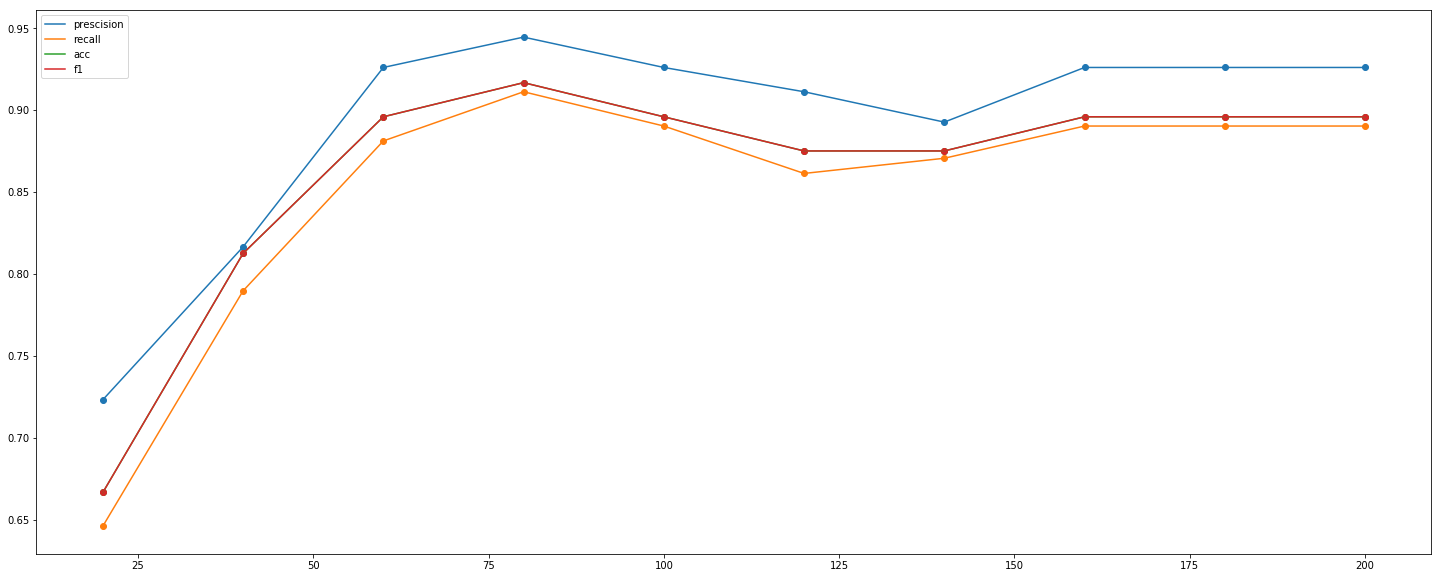

In [0]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [25, 10]
x= range(20,1+int(348*args["num_train_epochs"]/args["train_batch_size"]),args["save_steps"])

plt.plot(x,p,label="prescision")
plt.scatter(x,p)
plt.plot(x,r,label="recall")
plt.scatter(x,r)
plt.plot(x,a,label="acc")
plt.scatter(x,a)
#plt.plot(s,label="spec")
plt.plot(x,f,label="f1")
plt.scatter(x,f)
plt.legend()
plt.show()


In [0]:
!gsutil -m cp -r ./outputs_xlnet gs://qatar_competition/outputs_xlnet_10epochs_256seq_16batch_fp32

Copying file://./outputs_xlnet/eval_results.txt [Content-Type=text/plain]...
Copying file://./outputs_xlnet/checkpoint-240/pytorch_model.bin [Content-Type=application/octet-stream]...
Copying file://./outputs_xlnet/checkpoint-80/pytorch_model.bin [Content-Type=application/octet-stream]...
Copying file://./outputs_xlnet/checkpoint-80/config.json [Content-Type=application/json]...
Copying file://./outputs_xlnet/checkpoint-240/config.json [Content-Type=application/json]...
Copying file://./outputs_xlnet/checkpoint-180/pytorch_model.bin [Content-Type=application/octet-stream]...
Copying file://./outputs_xlnet/checkpoint-180/config.json [Content-Type=application/json]...
Copying file://./outputs_xlnet/checkpoint-200/config.json [Content-Type=application/json]...
Copying file://./outputs_xlnet/checkpoint-200/pytorch_model.bin [Content-Type=application/octet-stream]...
Copying file://./outputs_xlnet/checkpoint-20/pytorch_model.bin [Content-Type=application/octet-stream]...
==> NOTE: You are u

##Predictions

In [0]:
checkpoints = [args['output_dir']]
if args['eval_all_checkpoints']:
    checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
    logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
logger.info("Evaluate the following checkpoints: %s", checkpoints)
for checkpoint in checkpoints:
    global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
    model = model_class.from_pretrained(checkpoint)
    model.to(device)
    preds = predict(model, tokenizer, prefix=global_step)

In [0]:
print(preds)

In [0]:
for checkpoint in checkpoints:
  global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
  model = model_class.from_pretrained(checkpoint)
  model.to(device)
  result, wrong_preds = evaluate(model, tokenizer, prefix=global_step)
  result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
  results.update(result)


In [0]:
!gsutil -m cp -r ./outputs_xlnet gs://qatar_competition/outputs_xlnet_base_cased_english_topic/

Copying file://./outputs_xlnet/checkpoint-180/config.json [Content-Type=application/json]...
Copying file://./outputs_xlnet/checkpoint-60/config.json [Content-Type=application/json]...
Copying file://./outputs_xlnet/eval_results.txt [Content-Type=text/plain]...
Copying file://./outputs_xlnet/checkpoint-180/pytorch_model.bin [Content-Type=application/octet-stream]...
Copying file://./outputs_xlnet/checkpoint-60/pytorch_model.bin [Content-Type=application/octet-stream]...
Copying file://./outputs_xlnet/checkpoint-280/config.json [Content-Type=application/json]...
Copying file://./outputs_xlnet/checkpoint-360/config.json [Content-Type=application/json]...
Copying file://./outputs_xlnet/checkpoint-360/pytorch_model.bin [Content-Type=application/octet-stream]...
Copying file://./outputs_xlnet/checkpoint-280/pytorch_model.bin [Content-Type=application/octet-stream]...
Copying file://./outputs_xlnet/checkpoint-300/config.json [Content-Type=application/json]...
==> NOTE: You are uploading one 

In [0]:
!mv ./data/train.tsv ./data/temp.tsv
!mv ./data/dev.tsv ./data/train.tsv
!mv ./data/temp.tsv ./data/dev.tsv

#Fine-tuning Transformers (BERT)




##Installing and Importing Libraries

In [0]:
USE_BUCKET = True #@param {type:"boolean"}

if USE_BUCKET:
  from google.colab import auth
  auth.authenticate_user()

In [0]:
!rm -r outputs_*

In [0]:
!pip install pytorch_transformers
!pip install tensorboardX
!gsutil cp gs://qatar_competition/multiutils.py ./
!gsutil cp gs://qatar_competition/modeling.py ./

In [0]:
!mkdir data_topic
!gsutil cp -r gs://qatar_competition/data_topic ./

Copying gs://qatar_competition/data_topic/dev.tsv...
Copying gs://qatar_competition/data_topic/train.tsv...
- [2 files][317.0 KiB/317.0 KiB]                                                
Operation completed over 2 objects/317.0 KiB.                                    


In [0]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

Writing setup.sh


In [0]:
!sh setup.sh

In [0]:
from __future__ import absolute_import, division, print_function

import glob
import logging
import os
import random
import json

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import random
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm_notebook, trange
from tensorboardX import SummaryWriter

from modeling import BertForMultiLabelSequenceClassification, XLNetForMultiLabelSequenceClassification, RobertaForMultiLabelSequenceClassification, DistilBertForMultiLabelSequenceClassification

from pytorch_transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)

from pytorch_transformers import AdamW, WarmupLinearSchedule

from multiutils import (convert_examples_to_features,
                        output_modes, processors)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

##Initializing Arguments

In [0]:
args = {
    'data_dir': 'data_topic/',
    'model_type':  'bert',
    'model_name': 'bert-base-cased',
    'task_name': 'multi',
    'output_dir': 'outputs_bert/',
    'cache_dir': 'cache/',
    'do_train': True,
    'do_eval': True,
    'fp16': False,
    'fp16_opt_level': 'O1',
    'max_seq_length': 364,
    'output_mode': 'classification',
    'train_batch_size': 8,
    'eval_batch_size': 8,
    'gradient_accumulation_steps': 1,
    'num_train_epochs': 10,
    'weight_decay': 0,
    'learning_rate': 1e-5,
    'adam_epsilon': 1e-8,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 50,
    'evaluate_during_training': False,
    'save_steps': 20,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': False,
    'reprocess_input_data': True,
    'notes': 'Using Qatar Fake News dataset'
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
args

{'adam_epsilon': 1e-08,
 'cache_dir': 'cache/',
 'data_dir': 'data_topic/',
 'do_eval': True,
 'do_train': True,
 'eval_all_checkpoints': True,
 'eval_batch_size': 8,
 'evaluate_during_training': False,
 'fp16': False,
 'fp16_opt_level': 'O1',
 'gradient_accumulation_steps': 1,
 'learning_rate': 1e-05,
 'logging_steps': 50,
 'max_grad_norm': 1.0,
 'max_seq_length': 364,
 'model_name': 'bert-base-cased',
 'model_type': 'bert',
 'notes': 'Using Qatar Fake News dataset',
 'num_train_epochs': 10,
 'output_dir': 'outputs_bert/',
 'output_mode': 'classification',
 'overwrite_output_dir': False,
 'reprocess_input_data': True,
 'save_steps': 20,
 'task_name': 'multi',
 'train_batch_size': 8,
 'warmup_steps': 0,
 'weight_decay': 0}

In [0]:
with open('args.json', 'w') as f:
    json.dump(args, f)

In [0]:
if os.path.exists(args['output_dir']) and os.listdir(args['output_dir']) and args['do_train'] and not args['overwrite_output_dir']:
    raise ValueError("Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(args['output_dir']))

In [0]:
MODEL_CLASSES = {
    'bert': (BertConfig, BertForMultiLabelSequenceClassification, BertTokenizer),
    'xlnet': (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    'xlm': (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    'roberta': (RobertaConfig, RobertaForMultiLabelSequenceClassification, RobertaTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES[args['model_type']]

##Importing Models

In [0]:
task = args['task_name']

if task in processors.keys() and task in output_modes.keys():
    processor = processors[task]()
    Label_list = processor.get_labels(6)
    num_labels = len(Label_list)
else:
    raise KeyError(f'{task} not found in processors or in output_modes. Please check utils.py.')

In [0]:
config = config_class.from_pretrained(args['model_name'], num_labels=num_labels, finetuning_task=args['task_name'])
tokenizer = tokenizer_class.from_pretrained(args['model_name'])

INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /root/.cache/torch/pytorch_transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.d7a3af18ce3a2ab7c0f48f04dc8daff45ed9a3ed333b9e9a79d012a0dedf87a6
INFO:pytorch_transformers.modeling_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "multi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 6,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:pytorch_transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-

In [0]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
model = model_class.from_pretrained(args['model_name'],config=config)

INFO:pytorch_transformers.modeling_utils:loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-pytorch_model.bin from cache at /root/.cache/torch/pytorch_transformers/35d8b9d36faaf46728a0192d82bf7d00137490cd6074e8500778afed552a67e5.3fadbea36527ae472139fe84cddaa65454d7429f12d543d80bfc3ad70de55ac2
INFO:pytorch_transformers.modeling_utils:Weights of BertForMultiLabelSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
INFO:pytorch_transformers.modeling_utils:Weights from pretrained model not used in BertForMultiLabelSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']


In [0]:
model.to(device);

##Defining Utility Functions

In [0]:
def load_and_cache_examples(task, tokenizer, mode="train"):
    processor = processors[task]()
    output_mode = args['output_mode']
    
    #mode = 'dev' if evaluate else 'train'
    cached_features_file = os.path.join(args['data_dir'], f"cached_{mode}_{args['model_name']}_{args['max_seq_length']}_{task}")
    
    if os.path.exists(cached_features_file) and not args['reprocess_input_data']:
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
               
    else:
        logger.info("Creating features from dataset file at %s", args['data_dir'])
        label_list = Label_list
        if mode=="train":
          examples=processor.get_train_examples(args['data_dir']);
        if mode=="dev":
          examples=processor.get_dev_examples(args['data_dir']);
        if mode=="predict":
          examples=processor.get_predict_examples(args['data_dir'])
        #examples = processor.get_dev_examples(args['data_dir']) if evaluate else processor.get_train_examples(args['data_dir'])
        
        if __name__ == "__main__":
            features = convert_examples_to_features(examples, label_list, args['max_seq_length'], tokenizer, output_mode,
                cls_token_at_end=bool(args['model_type'] in ['xlnet']),            # xlnet has a cls token at the end
                cls_token=tokenizer.cls_token,
                cls_token_segment_id=2 if args['model_type'] in ['xlnet'] else 0,
                sep_token=tokenizer.sep_token,
                sep_token_extra=bool(args['model_type'] in ['roberta']),           # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                pad_on_left=bool(args['model_type'] in ['xlnet']),                 # pad on the left for xlnet
                pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                pad_token_segment_id=4 if args['model_type'] in ['xlnet'] else 0)
        
        logger.info("Saving features into cached file %s", cached_features_file)
        torch.save(features, cached_features_file)
        
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    return dataset

In [0]:
def train(train_dataset, model, tokenizer):
    tb_writer = SummaryWriter()
    
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args['train_batch_size'])
    
    t_total = len(train_dataloader) // args['gradient_accumulation_steps'] * args['num_train_epochs']
    
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args['weight_decay']},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args['learning_rate'], eps=args['adam_epsilon'])
    scheduler = WarmupLinearSchedule(optimizer, warmup_steps=args['warmup_steps'], t_total=t_total)
    
    if args['fp16']:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args['fp16_opt_level'])
        
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args['num_train_epochs'])
    logger.info("  Total train batch size  = %d", args['train_batch_size'])
    logger.info("  Gradient Accumulation steps = %d", args['gradient_accumulation_steps'])
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(int(args['num_train_epochs']), desc="Epoch")
    
    for _ in train_iterator:
        epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
            print("\r%f" % loss, end='')

            if args['gradient_accumulation_steps'] > 1:
                loss = loss / args['gradient_accumulation_steps']

            if args['fp16']:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args['max_grad_norm'])
                
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), args['max_grad_norm'])

            tr_loss += loss.item()
            if (step + 1) % args['gradient_accumulation_steps'] == 0:
                scheduler.step()  # Update learning rate schedule
                optimizer.step()
                model.zero_grad()
                global_step += 1

                if args['logging_steps'] > 0 and global_step % args['logging_steps'] == 0:
                    # Log metrics
                    if args['evaluate_during_training']:  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar('eval_{}'.format(key), value, global_step)
                    tb_writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar('loss', (tr_loss - logging_loss)/args['logging_steps'], global_step)
                    logging_loss = tr_loss

                if args['save_steps'] > 0 and global_step % args['save_steps'] == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args['output_dir'], 'checkpoint-{}'.format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    logger.info("Saving model checkpoint to %s", output_dir)


    return global_step, tr_loss / global_step

In [0]:
from sklearn.metrics import mean_squared_error, matthews_corrcoef, multilabel_confusion_matrix ,classification_report,precision_recall_fscore_support,accuracy_score
from scipy.stats import pearsonr
import numpy as np

def get_mismatched(labels, preds):
    mismatched = labels != preds
    examples = processor.get_dev_examples(args['data_dir'])
    wrong = [i for (i, v) in zip(examples, mismatched) if v]
    
    return wrong

def get_eval_report(labels, preds):
    labels = np.argmax(labels,axis=1)
    #mcc = matthews_corrcoef(labels, preds)
    precision,recall,fscore,support = precision_recall_fscore_support(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)
    return {
        "precision": precision,
        "recall": recall,
        "fscore": fscore,
        "support": support,
        "accuracy": accuracy
    }, get_mismatched(labels, preds)

def compute_metrics(task_name, preds, labels):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def evaluate(model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args['output_dir']

    results = {}
    results_cr=[]
    EVAL_TASK = args['task_name']

    eval_dataset = load_and_cache_examples(EVAL_TASK, tokenizer, mode="dev")
    if not os.path.exists(eval_output_dir):
        os.makedirs(eval_output_dir)


    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args['eval_batch_size'])

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args['eval_batch_size'])
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    if args['output_mode'] == "classification":
        preds = np.argmax(preds, axis=1)
    elif args['output_mode'] == "regression":
        preds = np.squeeze(preds)
    result, wrong = compute_metrics(EVAL_TASK, preds, out_label_ids)
    print(classification_report(np.argmax(out_label_ids,axis=1),preds))
    
    results_cr.append(classification_report(np.argmax(out_label_ids,axis=1),preds))
    results.update(result)

    output_eval_file = os.path.join(eval_output_dir, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return results, wrong,results_cr

In [0]:
def predict(model, tokenizer, prefix=""):
  pred_output_dir = args['output_dir']
  
  results={}
  PRED_TASK = args['task_name']
  
  pred_dataset = load_and_cache_examples(PRED_TASK, tokenizer, mode='predict')
  if not os.path.exists(pred_output_dir):
    os.makedirs(pred_output_dir)
    
  
  pred_sampler = SequentialSampler(pred_dataset)
  pred_dataloader = DataLoader(pred_dataset, sampler=pred_sampler, batch_size=args['eval_batch_size'])
  
  # Eval!
  logger.info("***** Running prediction {} *****".format(prefix))
  logger.info("  Num examples = %d", len(pred_dataset))
  logger.info("  Batch size = %d", args['eval_batch_size'])
  
  preds = None
  for batch in pred_dataloader:
    with torch.no_grad():
      batch = tuple(t.to(device) for t in batch)
      inputs = {'input_ids': batch[0],'attention_mask': batch[1],'token_type_ids': batch[2],'labels': batch[3]}
      
      outputs = model(**inputs)
      _, logits = outputs[:2]
    if preds is None:
        preds = logits.detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)

  preds = np.argmax(preds, axis=1)
      
  return preds

##Training

In [0]:
if args['do_train']:
    train_dataset = load_and_cache_examples(task, tokenizer , mode="train")
    global_step, tr_loss = train(train_dataset, model, tokenizer)
    logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 384/384 [00:00<00:00, 395.09it/s]
INFO:__main__:Saving features into cached file data_topic/cached_train_bert-base-cased_364_multi
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 384
INFO:__main__:  Num Epochs = 10
INFO:__main__:  Total train batch size  = 8
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 480
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

0.844335

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0.565879

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-20


0.445632

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-40


0.466283

Epoch:  10%|█         | 1/10 [00:58<08:47, 58.61s/it]

0.406203

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-60


0.362845

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-80


0.363702

Epoch:  20%|██        | 2/10 [01:57<07:48, 58.57s/it]

0.355513

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-100


0.356793

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-120


0.294952

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-140


0.284384

Epoch:  30%|███       | 3/10 [02:57<06:53, 59.03s/it]

0.262442

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-160


0.240194

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-180


0.196886

Epoch:  40%|████      | 4/10 [03:55<05:52, 58.83s/it]

0.191169

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-200


0.176903

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-220


0.198578

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-240
Epoch:  50%|█████     | 5/10 [04:55<04:56, 59.26s/it]

0.142191

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-260


0.139124

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-280


0.138670

Epoch:  60%|██████    | 6/10 [05:52<03:54, 58.51s/it]

0.124593

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-300


0.138221

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-320


0.111927

Epoch:  70%|███████   | 7/10 [06:49<02:53, 57.90s/it]

0.114843

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-340


0.104641

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-360


0.109171

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-380


0.126898

Epoch:  80%|████████  | 8/10 [07:46<01:55, 57.73s/it]

0.112409

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-400


0.103301

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-420


0.103291

Epoch:  90%|█████████ | 9/10 [08:43<00:57, 57.40s/it]

0.098354

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-440


0.103198

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-460


0.102040

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-480
Epoch: 100%|██████████| 10/10 [09:40<00:00, 57.50s/it]
INFO:__main__: global_step = 480, average loss = 0.23148617610956232


Automatic pdb calling has been turned ON


In [0]:
label_map = {label : i for i, label in enumerate(Label_list)}

In [0]:
Label_list

['0', '1']

In [0]:
%pdb

Automatic pdb calling has been turned ON


In [0]:
import torch
torch.cuda.empty_cache()

In [0]:
if args['do_train']:
    if not os.path.exists(args['output_dir']):
            os.makedirs(args['output_dir'])
    logger.info("Saving model checkpoint to %s", args['output_dir'])
    
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(args['output_dir'])
    tokenizer.save_pretrained(args['output_dir'])
    torch.save(args, os.path.join(args['output_dir'], 'training_args.bin'))

INFO:__main__:Saving model checkpoint to outputs_bert/


##Evaluating

In [0]:
def get_num(file_name):
  s= file_name.split('-')[-1]
  if s=='outputs_bert':
    return 99999
  return int(s)

results = {}
results_cr = []
if args['do_eval']:
    checkpoints = [args['output_dir']]
    if args['eval_all_checkpoints']:
        checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
        logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
    logger.info("Evaluate the following checkpoints: %s", checkpoints)
    for checkpoint in sorted(checkpoints,reverse = True,key=get_num):
        print(checkpoint)
        global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
        model = model_class.from_pretrained(checkpoint)
        model.to(device)
        with torch.no_grad():
          result, wrong_preds,cr = evaluate(model, tokenizer, prefix=global_step)
          result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
          results.update(result)
          results_cr.append(cr)
        model.cpu()
        del model
        
        torch.cuda.empty_cache()

INFO:__main__:Evaluate the following checkpoints: ['outputs_bert/checkpoint-100', 'outputs_bert/checkpoint-120', 'outputs_bert/checkpoint-140', 'outputs_bert/checkpoint-160', 'outputs_bert/checkpoint-180', 'outputs_bert/checkpoint-20', 'outputs_bert/checkpoint-200', 'outputs_bert/checkpoint-220', 'outputs_bert/checkpoint-240', 'outputs_bert/checkpoint-260', 'outputs_bert/checkpoint-280', 'outputs_bert/checkpoint-300', 'outputs_bert/checkpoint-320', 'outputs_bert/checkpoint-340', 'outputs_bert/checkpoint-360', 'outputs_bert/checkpoint-380', 'outputs_bert/checkpoint-40', 'outputs_bert/checkpoint-400', 'outputs_bert/checkpoint-420', 'outputs_bert/checkpoint-440', 'outputs_bert/checkpoint-460', 'outputs_bert/checkpoint-480', 'outputs_bert/checkpoint-60', 'outputs_bert/checkpoint-80']


outputs_bert/checkpoint-480


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 320.96it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 480 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 480 *****
INFO:__main__:  accuracy = 0.8958333333333334
INFO:__main__:  fscore = 0.8977591036414565
INFO:__main__:  precision = 0.9074074074074073
INFO:__main__:  recall = 0.8958333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       1.00      1.00      1.00         8
           2       1.00      0.75      0.86         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       0.78      0.88      0.82         8

    accuracy                           0.90        48
   macro avg       0.91      0.90      0.90        48
weighted avg       0.91      0.90      0.90        48

outputs_bert/checkpoint-460


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 350.71it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 460 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 460 *****
INFO:__main__:  accuracy = 0.8958333333333334
INFO:__main__:  fscore = 0.8977591036414565
INFO:__main__:  precision = 0.9074074074074073
INFO:__main__:  recall = 0.8958333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       1.00      1.00      1.00         8
           2       1.00      0.75      0.86         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       0.78      0.88      0.82         8

    accuracy                           0.90        48
   macro avg       0.91      0.90      0.90        48
weighted avg       0.91      0.90      0.90        48

outputs_bert/checkpoint-440


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 314.01it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 440 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 440 *****
INFO:__main__:  accuracy = 0.8958333333333334
INFO:__main__:  fscore = 0.8977591036414565
INFO:__main__:  precision = 0.9074074074074073
INFO:__main__:  recall = 0.8958333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       1.00      1.00      1.00         8
           2       1.00      0.75      0.86         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       0.78      0.88      0.82         8

    accuracy                           0.90        48
   macro avg       0.91      0.90      0.90        48
weighted avg       0.91      0.90      0.90        48

outputs_bert/checkpoint-420


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 339.73it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 420 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 420 *****
INFO:__main__:  accuracy = 0.8958333333333334
INFO:__main__:  fscore = 0.8977591036414565
INFO:__main__:  precision = 0.9074074074074073
INFO:__main__:  recall = 0.8958333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       1.00      1.00      1.00         8
           2       1.00      0.75      0.86         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       0.78      0.88      0.82         8

    accuracy                           0.90        48
   macro avg       0.91      0.90      0.90        48
weighted avg       0.91      0.90      0.90        48

outputs_bert/checkpoint-400


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 333.17it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 400 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 400 *****
INFO:__main__:  accuracy = 0.8958333333333334
INFO:__main__:  fscore = 0.8977591036414565
INFO:__main__:  precision = 0.9074074074074073
INFO:__main__:  recall = 0.8958333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       1.00      1.00      1.00         8
           2       1.00      0.75      0.86         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       0.78      0.88      0.82         8

    accuracy                           0.90        48
   macro avg       0.91      0.90      0.90        48
weighted avg       0.91      0.90      0.90        48

outputs_bert/checkpoint-380


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 347.28it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 380 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 380 *****
INFO:__main__:  accuracy = 0.875
INFO:__main__:  fscore = 0.8771241830065359
INFO:__main__:  precision = 0.8835978835978836
INFO:__main__:  recall = 0.875
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       1.00      1.00      1.00         8
           2       0.86      0.75      0.80         8
           3       1.00      1.00      1.00         8
           4       1.00      0.88      0.93         8
           5       0.78      0.88      0.82         8

    accuracy                           0.88        48
   macro avg       0.88      0.88      0.88        48
weighted avg       0.88      0.88      0.88        48

outputs_bert/checkpoint-360


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 357.98it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 360 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 360 *****
INFO:__main__:  accuracy = 0.8333333333333334
INFO:__main__:  fscore = 0.8241452991452992
INFO:__main__:  precision = 0.8361111111111111
INFO:__main__:  recall = 0.8333333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.60      0.38      0.46         8
           1       1.00      1.00      1.00         8
           2       0.75      0.75      0.75         8
           3       1.00      1.00      1.00         8
           4       1.00      0.88      0.93         8
           5       0.67      1.00      0.80         8

    accuracy                           0.83        48
   macro avg       0.84      0.83      0.82        48
weighted avg       0.84      0.83      0.82        48

outputs_bert/checkpoint-340


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 329.81it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 340 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 340 *****
INFO:__main__:  accuracy = 0.8958333333333334
INFO:__main__:  fscore = 0.8977591036414565
INFO:__main__:  precision = 0.9074074074074073
INFO:__main__:  recall = 0.8958333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       1.00      1.00      1.00         8
           2       1.00      0.75      0.86         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       0.78      0.88      0.82         8

    accuracy                           0.90        48
   macro avg       0.91      0.90      0.90        48
weighted avg       0.91      0.90      0.90        48

outputs_bert/checkpoint-320


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 343.27it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 320 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 320 *****
INFO:__main__:  accuracy = 0.8958333333333334
INFO:__main__:  fscore = 0.8953703703703705
INFO:__main__:  precision = 0.9011904761904762
INFO:__main__:  recall = 0.8958333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       1.00      1.00      1.00         8
           2       0.86      0.75      0.80         8
           3       1.00      1.00      1.00         8
           4       1.00      0.88      0.93         8
           5       0.80      1.00      0.89         8

    accuracy                           0.90        48
   macro avg       0.90      0.90      0.90        48
weighted avg       0.90      0.90      0.90        48

outputs_bert/checkpoint-300


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 350.17it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 300 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 300 *****
INFO:__main__:  accuracy = 0.875
INFO:__main__:  fscore = 0.8771241830065359
INFO:__main__:  precision = 0.8835978835978836
INFO:__main__:  recall = 0.875
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       1.00      1.00      1.00         8
           2       0.86      0.75      0.80         8
           3       1.00      1.00      1.00         8
           4       1.00      0.88      0.93         8
           5       0.78      0.88      0.82         8

    accuracy                           0.88        48
   macro avg       0.88      0.88      0.88        48
weighted avg       0.88      0.88      0.88        48

outputs_bert/checkpoint-280


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 343.31it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 280 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 280 *****
INFO:__main__:  accuracy = 0.8541666666666666
INFO:__main__:  fscore = 0.8553104575163398
INFO:__main__:  precision = 0.8587962962962963
INFO:__main__:  recall = 0.8541666666666666
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       1.00      1.00      1.00         8
           2       0.75      0.75      0.75         8
           3       1.00      1.00      1.00         8
           4       1.00      0.88      0.93         8
           5       0.78      0.88      0.82         8

    accuracy                           0.85        48
   macro avg       0.86      0.85      0.86        48
weighted avg       0.86      0.85      0.86        48

outputs_bert/checkpoint-260


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 340.36it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 260 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 260 *****
INFO:__main__:  accuracy = 0.8333333333333334
INFO:__main__:  fscore = 0.8241452991452992
INFO:__main__:  precision = 0.8361111111111111
INFO:__main__:  recall = 0.8333333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.60      0.38      0.46         8
           1       1.00      1.00      1.00         8
           2       0.75      0.75      0.75         8
           3       1.00      1.00      1.00         8
           4       1.00      0.88      0.93         8
           5       0.67      1.00      0.80         8

    accuracy                           0.83        48
   macro avg       0.84      0.83      0.82        48
weighted avg       0.84      0.83      0.82        48

outputs_bert/checkpoint-240


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 100.24it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 240 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 240 *****
INFO:__main__:  accuracy = 0.8333333333333334
INFO:__main__:  fscore = 0.8241452991452992
INFO:__main__:  precision = 0.8361111111111111
INFO:__main__:  recall = 0.8333333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.60      0.38      0.46         8
           1       1.00      1.00      1.00         8
           2       0.75      0.75      0.75         8
           3       1.00      1.00      1.00         8
           4       1.00      0.88      0.93         8
           5       0.67      1.00      0.80         8

    accuracy                           0.83        48
   macro avg       0.84      0.83      0.82        48
weighted avg       0.84      0.83      0.82        48

outputs_bert/checkpoint-220


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 338.70it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 220 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 220 *****
INFO:__main__:  accuracy = 0.8541666666666666
INFO:__main__:  fscore = 0.8553104575163398
INFO:__main__:  precision = 0.8587962962962963
INFO:__main__:  recall = 0.8541666666666666
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       1.00      1.00      1.00         8
           2       0.75      0.75      0.75         8
           3       1.00      1.00      1.00         8
           4       1.00      0.88      0.93         8
           5       0.78      0.88      0.82         8

    accuracy                           0.85        48
   macro avg       0.86      0.85      0.86        48
weighted avg       0.86      0.85      0.86        48

outputs_bert/checkpoint-200


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 323.63it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 200 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 200 *****
INFO:__main__:  accuracy = 0.8333333333333334
INFO:__main__:  fscore = 0.8343954248366013
INFO:__main__:  precision = 0.8402777777777778
INFO:__main__:  recall = 0.8333333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       1.00      0.88      0.93         8
           2       0.75      0.75      0.75         8
           3       0.89      1.00      0.94         8
           4       1.00      0.88      0.93         8
           5       0.78      0.88      0.82         8

    accuracy                           0.83        48
   macro avg       0.84      0.83      0.83        48
weighted avg       0.84      0.83      0.83        48

outputs_bert/checkpoint-180


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 347.85it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 180 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 180 *****
INFO:__main__:  accuracy = 0.8333333333333334
INFO:__main__:  fscore = 0.8324074074074074
INFO:__main__:  precision = 0.8369047619047619
INFO:__main__:  recall = 0.8333333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       1.00      1.00      1.00         8
           2       0.75      0.75      0.75         8
           3       1.00      1.00      1.00         8
           4       1.00      0.88      0.93         8
           5       0.70      0.88      0.78         8

    accuracy                           0.83        48
   macro avg       0.84      0.83      0.83        48
weighted avg       0.84      0.83      0.83        48

outputs_bert/checkpoint-160


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 331.22it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 160 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 160 *****
INFO:__main__:  accuracy = 0.7708333333333334
INFO:__main__:  fscore = 0.75834832808517
INFO:__main__:  precision = 0.7643939393939395
INFO:__main__:  recall = 0.7708333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.40      0.25      0.31         8
           1       1.00      0.88      0.93         8
           2       0.75      0.75      0.75         8
           3       0.80      1.00      0.89         8
           4       1.00      0.88      0.93         8
           5       0.64      0.88      0.74         8

    accuracy                           0.77        48
   macro avg       0.76      0.77      0.76        48
weighted avg       0.76      0.77      0.76        48

outputs_bert/checkpoint-140


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 339.99it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 140 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 140 *****
INFO:__main__:  accuracy = 0.7708333333333334
INFO:__main__:  fscore = 0.7523692810457515
INFO:__main__:  precision = 0.7569444444444445
INFO:__main__:  recall = 0.7708333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.50      0.25      0.33         8
           1       0.88      0.88      0.88         8
           2       0.67      0.75      0.71         8
           3       0.80      1.00      0.89         8
           4       1.00      0.88      0.93         8
           5       0.70      0.88      0.78         8

    accuracy                           0.77        48
   macro avg       0.76      0.77      0.75        48
weighted avg       0.76      0.77      0.75        48

outputs_bert/checkpoint-120


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 326.95it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 120 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 120 *****
INFO:__main__:  accuracy = 0.7708333333333334
INFO:__main__:  fscore = 0.7540849673202614
INFO:__main__:  precision = 0.7632275132275131
INFO:__main__:  recall = 0.7708333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.50      0.25      0.33         8
           1       0.88      0.88      0.88         8
           2       0.86      0.75      0.80         8
           3       0.89      1.00      0.94         8
           4       0.88      0.88      0.88         8
           5       0.58      0.88      0.70         8

    accuracy                           0.77        48
   macro avg       0.76      0.77      0.75        48
weighted avg       0.76      0.77      0.75        48

outputs_bert/checkpoint-100


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 104.84it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 100 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 100 *****
INFO:__main__:  accuracy = 0.7083333333333334
INFO:__main__:  fscore = 0.7023755971124391
INFO:__main__:  precision = 0.7282828282828283
INFO:__main__:  recall = 0.7083333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.60      0.38      0.46         8
           1       0.64      0.88      0.74         8
           2       0.83      0.62      0.71         8
           3       0.80      1.00      0.89         8
           4       1.00      0.75      0.86         8
           5       0.50      0.62      0.56         8

    accuracy                           0.71        48
   macro avg       0.73      0.71      0.70        48
weighted avg       0.73      0.71      0.70        48

outputs_bert/checkpoint-80


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 296.28it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 80 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 80 *****
INFO:__main__:  accuracy = 0.4583333333333333
INFO:__main__:  fscore = 0.41874236874236875
INFO:__main__:  precision = 0.548015873015873
INFO:__main__:  recall = 0.4583333333333333
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.40      0.25      0.31         8
           1       0.50      0.12      0.20         8
           2       0.57      0.50      0.53         8
           3       0.40      1.00      0.57         8
           4       1.00      0.25      0.40         8
           5       0.42      0.62      0.50         8

    accuracy                           0.46        48
   macro avg       0.55      0.46      0.42        48
weighted avg       0.55      0.46      0.42        48

outputs_bert/checkpoint-60


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 345.16it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 60 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
INFO:__main__:***** Eval results 60 *****
INFO:__main__:  accuracy = 0.3541666666666667
INFO:__main__:  fscore = 0.30259324009324007
INFO:__main__:  precision = 0.38328853046594985
INFO:__main__:  recall = 0.3541666666666667
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.38      0.38      0.38         8
           2       0.67      0.25      0.36         8
           3       0.26      1.00      0.41         8
           4       0.00      0.00      0.00         8
           5       1.00      0.50      0.67         8

    accuracy                           0.35        48
   macro avg       0.38      0.35      0.30        48
weighted avg       0.38      0.35      0.30        48

outputs_bert/checkpoint-40


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 343.25it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 40 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 40 *****
INFO:__main__:  accuracy = 0.22916666666666666
INFO:__main__:  fscore = 0.14222222222222222
INFO:__main__:  precision = 0.1984126984126984
INFO:__main__:  recall = 0.22916666666666666
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.50      0.25      0.33         8
           2       0.50      0.12      0.20         8
           3       0.19      1.00      0.32         8
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00         8

    accuracy                           0.23        48
   macro avg       0.20      0.23      0.14        48
weighted avg       0.20      0.23      0.14        48

outputs_bert/checkpoint-20


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 306.16it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_bert-base-cased_364_multi
INFO:__main__:***** Running evaluation 20 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 20 *****
INFO:__main__:  accuracy = 0.16666666666666666
INFO:__main__:  fscore = 0.10185185185185186
INFO:__main__:  precision = 0.20833333333333334
INFO:__main__:  recall = 0.16666666666666666
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       1.00      0.12      0.22         8
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         8
           5       0.25      0.88      0.39         8

    accuracy                           0.17        48
   macro avg       0.21      0.17      0.10        48
weighted avg       0.21      0.17      0.10        48



In [0]:
results

{'accuracy_100': 0.8125,
 'accuracy_120': 0.8541666666666666,
 'accuracy_140': 0.8125,
 'accuracy_160': 0.875,
 'accuracy_180': 0.875,
 'accuracy_20': 0.20833333333333334,
 'accuracy_200': 0.8958333333333334,
 'accuracy_220': 0.8958333333333334,
 'accuracy_240': 0.8541666666666666,
 'accuracy_260': 0.8958333333333334,
 'accuracy_280': 0.8958333333333334,
 'accuracy_300': 0.8958333333333334,
 'accuracy_320': 0.8958333333333334,
 'accuracy_340': 0.875,
 'accuracy_360': 0.875,
 'accuracy_380': 0.875,
 'accuracy_40': 0.625,
 'accuracy_400': 0.875,
 'accuracy_420': 0.875,
 'accuracy_440': 0.875,
 'accuracy_460': 0.875,
 'accuracy_480': 0.875,
 'accuracy_60': 0.5833333333333334,
 'accuracy_80': 0.75,
 'accuracy_outputs_bert': 0.875,
 'fscore_100': 0.8124183006535949,
 'fscore_120': 0.8550821498189919,
 'fscore_140': 0.8060080442433383,
 'fscore_160': 0.8757002801120448,
 'fscore_180': 0.8747549019607842,
 'fscore_20': 0.11794871794871796,
 'fscore_200': 0.8960161842514783,
 'fscore_220': 0.8

In [0]:
def get_result_from_results(resutls,step="outputs"):
  precision = results["precision_"+str(step)]
  fscore = results["fscore_"+str(step)]
  recall = results["recall_"+str(step)]
  support = results["support_"+str(step)]
  accuracy = results["accuracy_"+str(step)]  
  return precision,fscore,recall,support,accuracy

def get_metrics(res):
  precision = res["tp"]/(res["fp"]+res["tp"])
  recall = res["tp"]/(res["fn"]+res["tp"])
  accuracy = (res["tp"]+res["tn"])/(res["fn"]+res["tp"]+res["tn"]+res["fp"])
  specificity = res["tn"]/(res["tn"]+res["fp"])
  f1 = (2*precision*recall)/(precision+recall)
  return precision,recall,accuracy,specificity,f1

In [0]:
res = get_result_from_results(results,"10")

In [0]:
step=20
precision,recall,accuracy,support,f1 = get_result_from_results(results,step)

print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("Accuracy: "+str(accuracy))
print("Specificity: "+str(support))
print("F1: "+str(f1))

Precision: 0.196969696969697
Recall: 0.11794871794871796
Accuracy: 0.20833333333333334
Specificity: None
F1: 0.20833333333333334


In [0]:
p=[]
r=[]
a=[]
#s=[]
f=[]
for i in range(20,1+int(348*args["num_train_epochs"]/args["train_batch_size"]),args["save_steps"]):
  try:
    res = get_result_from_results(results,i)
    precision,recall,accuracy,support,f1 = get_result_from_results(results,i)
    p.append(precision)
    r.append(recall)
    a.append(accuracy)
    #s.append(specificity)
    f.append(f1)
  except:
    print("can't find checkpoint: "+str(i))

In [0]:
get_result_from_results(results,20)

KeyError: ignored

In [0]:
res = get_result_from_results(results,"outputs")
precision,recall,accuracy,specificity,f1 = get_metrics(res)
p.append(precision)
r.append(recall)
a.append(accuracy)
s.append(specificity)
f.append(f1)

KeyError: ignored

In [0]:
p

[0.3111111111111111,
 0.3341750841750842,
 0.7308709808709809,
 0.6729497354497355,
 0.789402726902727,
 0.8744047619047618,
 0.8079212454212454,
 0.8331349206349207,
 0.8831168831168831,
 0.8831168831168831,
 0.9249999999999999,
 0.9249999999999999,
 0.9249999999999999,
 0.9249999999999999,
 0.9011904761904762,
 0.9249999999999999,
 0.9249999999999999,
 0.9249999999999999,
 0.9249999999999999,
 0.9249999999999999,
 0.9249999999999999]

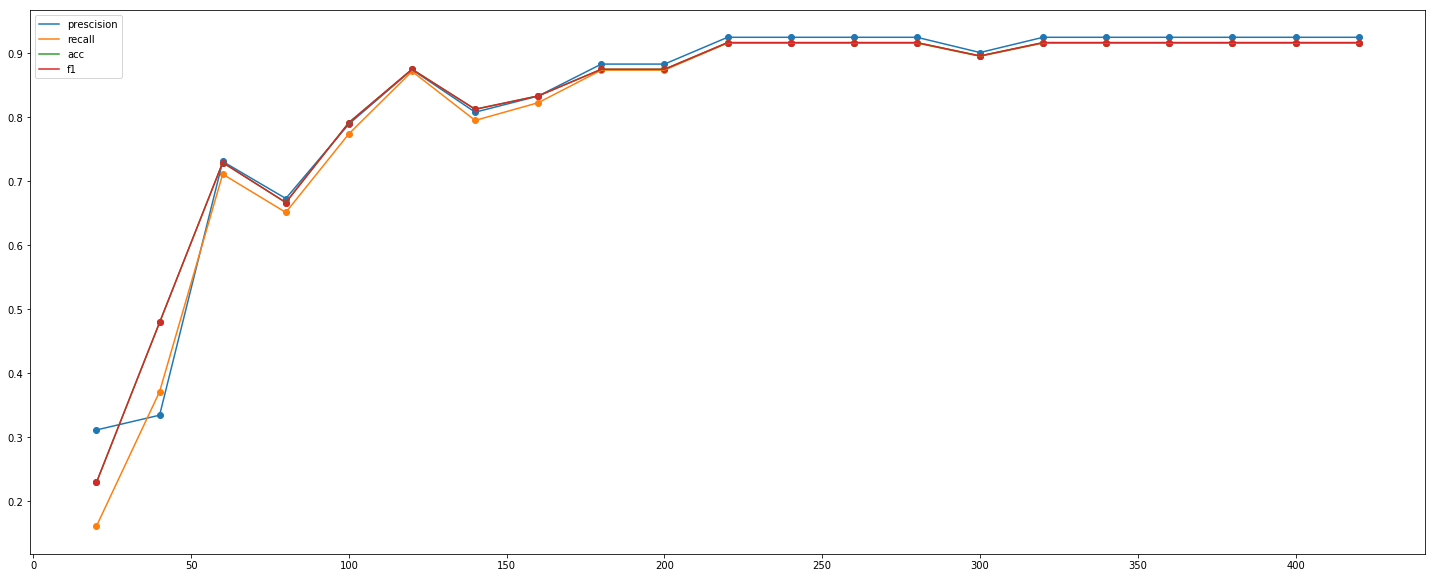

In [0]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [25, 10]
x= range(20,1+int(348*args["num_train_epochs"]/args["train_batch_size"]),args["save_steps"])

plt.plot(x,p,label="prescision")
plt.scatter(x,p)
plt.plot(x,r,label="recall")
plt.scatter(x,r)
plt.plot(x,a,label="acc")
plt.scatter(x,a)
#plt.plot(s,label="spec")
plt.plot(x,f,label="f1")
plt.scatter(x,f)
plt.legend()
plt.show()


In [0]:
!cp ./data/dev.tsv

##Predictions

In [0]:
checkpoints = [args['output_dir']]
if args['eval_all_checkpoints']:
    checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
    logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
logger.info("Evaluate the following checkpoints: %s", checkpoints)
for checkpoint in checkpoints:
    global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
    model = model_class.from_pretrained(checkpoint)
    model.to(device)
    preds = predict(model, tokenizer, prefix=global_step)

In [0]:
print(preds)

In [0]:
for checkpoint in checkpoints:
  global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
  model = model_class.from_pretrained(checkpoint)
  model.to(device)
  result, wrong_preds = evaluate(model, tokenizer, prefix=global_step)
  result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
  results.update(result)


In [0]:
!gsutil -m cp -r ./outputs_bert gs://qatar_competition/outputs_bert_base_cased_english_topic/

Copying file://./outputs_bert/eval_results.txt [Content-Type=text/plain]...
Copying file://./outputs_bert/tokenizer_config.json [Content-Type=application/json]...
Copying file://./outputs_bert/config.json [Content-Type=application/json]...
Copying file://./outputs_bert/vocab.txt [Content-Type=text/plain]...
Copying file://./outputs_bert/added_tokens.json [Content-Type=application/json]...
Copying file://./outputs_bert/special_tokens_map.json [Content-Type=application/json]...
Copying file://./outputs_bert/pytorch_model.bin [Content-Type=application/octet-stream]...
Copying file://./outputs_bert/training_args.bin [Content-Type=application/octet-stream]...
Copying file://./outputs_bert/checkpoint-60/config.json [Content-Type=application/json]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configurati

In [0]:
!mv ./data/train.tsv ./data/temp.tsv
!mv ./data/dev.tsv ./data/train.tsv
!mv ./data/temp.tsv ./data/dev.tsv

#Fine-tuning Transformers (RoBERTa)




##Installing and Importing Libraries

In [0]:
USE_BUCKET = True #@param {type:"boolean"}

if USE_BUCKET:
  from google.colab import auth
  auth.authenticate_user()

In [0]:
!rm -r data_topic

In [0]:
!pip install pytorch_transformers
!pip install tensorboardX
!gsutil cp gs://qatar_competition/multiutils.py ./
!gsutil cp gs://qatar_competition/modeling.py ./

Copying gs://qatar_competition/multiutils.py...
/ [1 files][ 15.1 KiB/ 15.1 KiB]                                                
Operation completed over 1 objects/15.1 KiB.                                     
Copying gs://qatar_competition/modeling.py...
/ [1 files][ 13.2 KiB/ 13.2 KiB]                                                
Operation completed over 1 objects/13.2 KiB.                                     


In [0]:
!mkdir data_topic_eval
!gsutil cp -r gs://qatar_competition/data_topic_eval ./

Copying gs://qatar_competition/data_topic_eval/predict.tsv...
Copying gs://qatar_competition/data_topic_eval/train.tsv...
- [2 files][355.0 KiB/355.0 KiB]                                                
Operation completed over 2 objects/355.0 KiB.                                    


In [0]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

Writing setup.sh


In [0]:
!sh setup.sh

In [0]:
from __future__ import absolute_import, division, print_function

import glob
import logging
import os
import random
import json

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import random
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm_notebook, trange
from tensorboardX import SummaryWriter

from modeling import BertForMultiLabelSequenceClassification, XLNetForMultiLabelSequenceClassification, RobertaForMultiLabelSequenceClassification, DistilBertForMultiLabelSequenceClassification

from pytorch_transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)

from pytorch_transformers import AdamW, WarmupLinearSchedule

from multiutils import (convert_examples_to_features,
                        output_modes, processors)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

##Initializing Arguments

In [0]:
args = {
    'data_dir': 'data_topic_eval/',
    'model_type':  'roberta',
    'model_name': 'roberta-base',
    'task_name': 'multi',
    'output_dir': 'outputs_bert/',
    'cache_dir': 'cache/',
    'do_train': True,
    'do_eval': True,
    'fp16': False,
    'fp16_opt_level': 'O1',
    'max_seq_length': 364,
    'output_mode': 'classification',
    'train_batch_size': 8,
    'eval_batch_size': 8,
    'gradient_accumulation_steps': 1,
    'num_train_epochs': 10,
    'weight_decay': 0,
    'learning_rate': 2e-5,
    'adam_epsilon': 1e-8,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 50,
    'evaluate_during_training': False,
    'save_steps': 20,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': False,
    'reprocess_input_data': True,
    'notes': 'Using Qatar Fake News dataset'
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
args

{'adam_epsilon': 1e-08,
 'cache_dir': 'cache/',
 'data_dir': 'data_topic_eval/',
 'do_eval': True,
 'do_train': True,
 'eval_all_checkpoints': True,
 'eval_batch_size': 8,
 'evaluate_during_training': False,
 'fp16': False,
 'fp16_opt_level': 'O1',
 'gradient_accumulation_steps': 1,
 'learning_rate': 2e-05,
 'logging_steps': 50,
 'max_grad_norm': 1.0,
 'max_seq_length': 364,
 'model_name': 'roberta-base',
 'model_type': 'roberta',
 'notes': 'Using Qatar Fake News dataset',
 'num_train_epochs': 10,
 'output_dir': 'outputs_bert/',
 'output_mode': 'classification',
 'overwrite_output_dir': False,
 'reprocess_input_data': True,
 'save_steps': 20,
 'task_name': 'multi',
 'train_batch_size': 8,
 'warmup_steps': 0,
 'weight_decay': 0}

In [0]:
with open('args.json', 'w') as f:
    json.dump(args, f)

In [0]:
if os.path.exists(args['output_dir']) and os.listdir(args['output_dir']) and args['do_train'] and not args['overwrite_output_dir']:
    raise ValueError("Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(args['output_dir']))

In [0]:
MODEL_CLASSES = {
    'bert': (BertConfig, BertForMultiLabelSequenceClassification, BertTokenizer),
    'xlnet': (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    'xlm': (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    'roberta': (RobertaConfig, RobertaForMultiLabelSequenceClassification, RobertaTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES[args['model_type']]

##Importing Models

In [0]:
task = args['task_name']

if task in processors.keys() and task in output_modes.keys():
    processor = processors[task]()
    Label_list = processor.get_labels(6)
    num_labels = len(Label_list)
else:
    raise KeyError(f'{task} not found in processors or in output_modes. Please check utils.py.')

In [0]:
config = config_class.from_pretrained(args['model_name'], num_labels=num_labels, finetuning_task=args['task_name'])
tokenizer = tokenizer_class.from_pretrained(args['model_name'])

INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /root/.cache/torch/pytorch_transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.9dad9043216064080cf9dd3711c53c0f11fe2b09313eaa66931057b4bdcaf068
INFO:pytorch_transformers.modeling_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "multi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 6,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "vocab_size": 50265
}

INFO:pytorch_transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-

In [0]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
model = model_class.from_pretrained(args['model_name'],config=config)

INFO:pytorch_transformers.modeling_utils:loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-pytorch_model.bin from cache at /root/.cache/torch/pytorch_transformers/228756ed15b6d200d7cb45aaef08c087e2706f54cb912863d2efe07c89584eb7.49b88ba7ec2c26a7558dda98ca3884c3b80fa31cf43a1b1f23aef3ff81ba344e
INFO:pytorch_transformers.modeling_utils:Weights of RobertaForMultiLabelSequenceClassification not initialized from pretrained model: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
INFO:pytorch_transformers.modeling_utils:Weights from pretrained model not used in RobertaForMultiLabelSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']


In [0]:
model.to(device);

##Defining Utility Functions

In [0]:
def load_and_cache_examples(task, tokenizer, mode="train"):
    processor = processors[task]()
    output_mode = args['output_mode']
    
    #mode = 'dev' if evaluate else 'train'
    cached_features_file = os.path.join(args['data_dir'], f"cached_{mode}_{args['model_name']}_{args['max_seq_length']}_{task}")
    
    if os.path.exists(cached_features_file) and not args['reprocess_input_data']:
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
               
    else:
        logger.info("Creating features from dataset file at %s", args['data_dir'])
        label_list = Label_list
        if mode=="train":
          examples=processor.get_train_examples(args['data_dir']);
        if mode=="dev":
          examples=processor.get_dev_examples(args['data_dir']);
        if mode=="predict":
          examples=processor.get_predict_examples(args['data_dir'])
        #examples = processor.get_dev_examples(args['data_dir']) if evaluate else processor.get_train_examples(args['data_dir'])
        
        if __name__ == "__main__":
            features = convert_examples_to_features(examples, label_list, args['max_seq_length'], tokenizer, output_mode,
                cls_token_at_end=bool(args['model_type'] in ['xlnet']),            # xlnet has a cls token at the end
                cls_token=tokenizer.cls_token,
                cls_token_segment_id=2 if args['model_type'] in ['xlnet'] else 0,
                sep_token=tokenizer.sep_token,
                sep_token_extra=bool(args['model_type'] in ['roberta']),           # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                pad_on_left=bool(args['model_type'] in ['xlnet']),                 # pad on the left for xlnet
                pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                pad_token_segment_id=4 if args['model_type'] in ['xlnet'] else 0)
        
        logger.info("Saving features into cached file %s", cached_features_file)
        torch.save(features, cached_features_file)
    #raise TypeError
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    return dataset

In [0]:
def train(train_dataset, model, tokenizer):
    tb_writer = SummaryWriter()
    
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args['train_batch_size'])
    
    t_total = len(train_dataloader) // args['gradient_accumulation_steps'] * args['num_train_epochs']
    
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args['weight_decay']},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args['learning_rate'], eps=args['adam_epsilon'])
    scheduler = WarmupLinearSchedule(optimizer, warmup_steps=args['warmup_steps'], t_total=t_total)
    
    if args['fp16']:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args['fp16_opt_level'])
        
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args['num_train_epochs'])
    logger.info("  Total train batch size  = %d", args['train_batch_size'])
    logger.info("  Gradient Accumulation steps = %d", args['gradient_accumulation_steps'])
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(int(args['num_train_epochs']), desc="Epoch")
    
    for _ in train_iterator:
        epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
            print("\r%f" % loss, end='')

            if args['gradient_accumulation_steps'] > 1:
                loss = loss / args['gradient_accumulation_steps']

            if args['fp16']:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args['max_grad_norm'])
                
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), args['max_grad_norm'])

            tr_loss += loss.item()
            if (step + 1) % args['gradient_accumulation_steps'] == 0:
                scheduler.step()  # Update learning rate schedule
                optimizer.step()
                model.zero_grad()
                global_step += 1

                if args['logging_steps'] > 0 and global_step % args['logging_steps'] == 0:
                    # Log metrics
                    if args['evaluate_during_training']:  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar('eval_{}'.format(key), value, global_step)
                    tb_writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar('loss', (tr_loss - logging_loss)/args['logging_steps'], global_step)
                    logging_loss = tr_loss

                if args['save_steps'] > 0 and global_step % args['save_steps'] == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args['output_dir'], 'checkpoint-{}'.format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    logger.info("Saving model checkpoint to %s", output_dir)


    return global_step, tr_loss / global_step

In [0]:
from sklearn.metrics import mean_squared_error, matthews_corrcoef, multilabel_confusion_matrix ,classification_report,precision_recall_fscore_support,accuracy_score
from scipy.stats import pearsonr
import numpy as np

def get_mismatched(labels, preds):
    mismatched = labels != preds
    examples = processor.get_dev_examples(args['data_dir'])
    wrong = [i for (i, v) in zip(examples, mismatched) if v]
    
    return wrong

def get_eval_report(labels, preds):
    labels = np.argmax(labels,axis=1)
    #mcc = matthews_corrcoef(labels, preds)
    precision,recall,fscore,support = precision_recall_fscore_support(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)
    return {
        "precision": precision,
        "recall": recall,
        "fscore": fscore,
        "support": support,
        "accuracy": accuracy
    }, get_mismatched(labels, preds)

def compute_metrics(task_name, preds, labels):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def evaluate(model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args['output_dir']

    results = {}
    results_cr=[]
    EVAL_TASK = args['task_name']

    eval_dataset = load_and_cache_examples(EVAL_TASK, tokenizer, mode="dev")
    if not os.path.exists(eval_output_dir):
        os.makedirs(eval_output_dir)


    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args['eval_batch_size'])

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args['eval_batch_size'])
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    if args['output_mode'] == "classification":
        preds = np.argmax(preds, axis=1)
    elif args['output_mode'] == "regression":
        preds = np.squeeze(preds)
    result, wrong = compute_metrics(EVAL_TASK, preds, out_label_ids)
    print(classification_report(np.argmax(out_label_ids,axis=1),preds))
    
    results_cr.append(classification_report(np.argmax(out_label_ids,axis=1),preds))
    results.update(result)

    output_eval_file = os.path.join(eval_output_dir, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return results, wrong,results_cr

In [0]:
def predict(model, tokenizer, prefix=""):
  pred_output_dir = args['output_dir']
  
  results={}
  PRED_TASK = args['task_name']
  
  pred_dataset = load_and_cache_examples(PRED_TASK, tokenizer, mode='predict')
  if not os.path.exists(pred_output_dir):
    os.makedirs(pred_output_dir)
    
  
  pred_sampler = SequentialSampler(pred_dataset)
  pred_dataloader = DataLoader(pred_dataset, sampler=pred_sampler, batch_size=args['eval_batch_size'])
  
  # Eval!
  logger.info("***** Running prediction {} *****".format(prefix))
  logger.info("  Num examples = %d", len(pred_dataset))
  logger.info("  Batch size = %d", args['eval_batch_size'])
  
  preds = None
  for batch in pred_dataloader:
    with torch.no_grad():
      batch = tuple(t.to(device) for t in batch)
      inputs = {'input_ids': batch[0],'attention_mask': batch[1],'token_type_ids': batch[2],'labels': batch[3]}
      
      outputs = model(**inputs)
      _, logits = outputs[:2]
    if preds is None:
        preds = logits.detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)

  preds = np.argmax(preds, axis=1)
      
  return preds

##Training

In [0]:
if args['do_train']:
    train_dataset = load_and_cache_examples(task, tokenizer , mode="train")
    global_step, tr_loss = train(train_dataset, model, tokenizer)
    logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

INFO:__main__:Creating features from dataset file at data_topic_eval/
100%|██████████| 432/432 [00:00<00:00, 522.42it/s]
INFO:__main__:Saving features into cached file data_topic_eval/cached_train_roberta-base_364_multi
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 432
INFO:__main__:  Num Epochs = 10
INFO:__main__:  Total train batch size  = 8
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 540
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

0.697188

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0.462563

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-20


0.416283

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-40


0.330644

Epoch:  10%|█         | 1/10 [01:06<09:55, 66.17s/it]

0.309294

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-60


0.291463

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-80


0.153769

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-100


0.183255

Epoch:  20%|██        | 2/10 [02:12<08:50, 66.36s/it]

0.180759

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-120


0.087515

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-140


0.078880

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-160


0.144988

Epoch:  30%|███       | 3/10 [03:19<07:45, 66.45s/it]

0.065041

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-180


0.114772

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-200


0.052575

Epoch:  40%|████      | 4/10 [04:23<06:34, 65.79s/it]

0.051658

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-220


0.044883

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-240


0.041541

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-260


0.039501

Epoch:  50%|█████     | 5/10 [05:29<05:28, 65.65s/it]

0.041138

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-280


0.036586

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-300


0.034287

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-320


0.034630

Epoch:  60%|██████    | 6/10 [06:34<04:22, 65.55s/it]

0.033202

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-340


0.032639

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-360


0.028735

Epoch:  70%|███████   | 7/10 [07:38<03:15, 65.14s/it]

0.033017

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-380


0.029925

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-400


0.029642

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-420


0.029267

Epoch:  80%|████████  | 8/10 [08:44<02:10, 65.29s/it]

0.028794

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-440


0.027656

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-460


0.027266

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-480


0.027282

Epoch:  90%|█████████ | 9/10 [09:49<01:05, 65.37s/it]

0.026418

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-500


0.026386

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-520


0.026593

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-540
Epoch: 100%|██████████| 10/10 [10:55<00:00, 65.40s/it]
INFO:__main__: global_step = 540, average loss = 0.10926764967885834


In [0]:
label_map = {label : i for i, label in enumerate(Label_list)}

In [0]:
Label_list

['0', '1']

In [0]:
%pdb

Automatic pdb calling has been turned ON


In [0]:
import torch
torch.cuda.empty_cache()

In [0]:
if args['do_train']:
    if not os.path.exists(args['output_dir']):
            os.makedirs(args['output_dir'])
    logger.info("Saving model checkpoint to %s", args['output_dir'])
    
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(args['output_dir'])
    tokenizer.save_pretrained(args['output_dir'])
    torch.save(args, os.path.join(args['output_dir'], 'training_args.bin'))

INFO:__main__:Saving model checkpoint to outputs_bert/


##Evaluating

In [0]:
!mkdir outputs_bert
!gsutil -m cp -r gs://qatar_competition/outputs_roberta_base_english_topic_fp32_364seqlen/ ./outputs_bert

Copying gs://qatar_competition/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-120/pytorch_model.bin...
Copying gs://qatar_competition/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-100/pytorch_model.bin...
Copying gs://qatar_competition/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-140/pytorch_model.bin...
Copying gs://qatar_competition/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-100/config.json...
Copying gs://qatar_competition/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-120/config.json...
Copying gs://qatar_competition/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-140/config.json...
Copying gs://qatar_competition/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-180/config.json...
Copying gs://qatar_competition/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-160/confi

In [0]:
def get_num(file_name):
  s= file_name.split('-')[-1]
  if s=='outputs_bert':
    return 99999
  return int(s)

results = {}
results_cr = []
if args['do_eval']:
    checkpoints = [args['output_dir']]
    if args['eval_all_checkpoints']:
        checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
        logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
    logger.info("Evaluate the following checkpoints: %s", checkpoints)
    for checkpoint in sorted(checkpoints,reverse = True,key=get_num):
        print(checkpoint)
        global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
        model = model_class.from_pretrained(checkpoint)
        model.to(device)
        with torch.no_grad():
          result, wrong_preds,cr = evaluate(model, tokenizer, prefix=global_step)
          result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
          results.update(result)
          results_cr.append(cr)
        model.cpu()
        del model
        torch.cuda.empty_cache()

INFO:__main__:Evaluate the following checkpoints: ['outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-100', 'outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-120', 'outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-140', 'outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-160', 'outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-180', 'outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-20', 'outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-200', 'outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-220', 'outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-240', 'outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-260', 'outputs_b

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-480


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 167.97it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 480 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 480 *****
INFO:__main__:  accuracy = 0.9166666666666666
INFO:__main__:  fscore = 0.9160597572362278
INFO:__main__:  precision = 0.9259259259259259
INFO:__main__:  recall = 0.9166666666666666
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       1.00      0.88      0.93         8
           2       1.00      0.75      0.86         8
           3       0.89      1.00      0.94         8
           4       1.00      1.00      1.00         8
           5       0.89      1.00      0.94         8

    accuracy                           0.92        48
   macro avg       0.93      0.92      0.92        48
weighted avg       0.93      0.92      0.92        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-460


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:01<00:00, 43.15it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 460 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 460 *****
INFO:__main__:  accuracy = 0.9375
INFO:__main__:  fscore = 0.9369747899159665
INFO:__main__:  precision = 0.9444444444444443
INFO:__main__:  recall = 0.9375
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       1.00      1.00      1.00         8
           2       1.00      0.75      0.86         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       0.89      1.00      0.94         8

    accuracy                           0.94        48
   macro avg       0.94      0.94      0.94        48
weighted avg       0.94      0.94      0.94        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-440


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 153.43it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 440 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 440 *****
INFO:__main__:  accuracy = 0.9166666666666666
INFO:__main__:  fscore = 0.9160052910052912
INFO:__main__:  precision = 0.9249999999999999
INFO:__main__:  recall = 0.9166666666666666
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       1.00      1.00      1.00         8
           2       1.00      0.75      0.86         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       0.80      1.00      0.89         8

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.92        48
weighted avg       0.92      0.92      0.92        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-420


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 91.41it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 420 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 420 *****
INFO:__main__:  accuracy = 0.9166666666666666
INFO:__main__:  fscore = 0.9160052910052912
INFO:__main__:  precision = 0.9249999999999999
INFO:__main__:  recall = 0.9166666666666666
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       1.00      1.00      1.00         8
           2       1.00      0.75      0.86         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       0.80      1.00      0.89         8

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.92        48
weighted avg       0.92      0.92      0.92        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-400


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 227.29it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 400 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 400 *****
INFO:__main__:  accuracy = 0.9375
INFO:__main__:  fscore = 0.9369747899159665
INFO:__main__:  precision = 0.9444444444444443
INFO:__main__:  recall = 0.9375
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       1.00      1.00      1.00         8
           2       1.00      0.75      0.86         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       0.89      1.00      0.94         8

    accuracy                           0.94        48
   macro avg       0.94      0.94      0.94        48
weighted avg       0.94      0.94      0.94        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-380


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 154.31it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 380 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 380 *****
INFO:__main__:  accuracy = 0.9375
INFO:__main__:  fscore = 0.9369747899159665
INFO:__main__:  precision = 0.9444444444444443
INFO:__main__:  recall = 0.9375
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       1.00      1.00      1.00         8
           2       1.00      0.75      0.86         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       0.89      1.00      0.94         8

    accuracy                           0.94        48
   macro avg       0.94      0.94      0.94        48
weighted avg       0.94      0.94      0.94        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-360


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 228.45it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 360 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 360 *****
INFO:__main__:  accuracy = 0.9375
INFO:__main__:  fscore = 0.9369747899159665
INFO:__main__:  precision = 0.9444444444444443
INFO:__main__:  recall = 0.9375
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       1.00      1.00      1.00         8
           2       1.00      0.75      0.86         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       0.89      1.00      0.94         8

    accuracy                           0.94        48
   macro avg       0.94      0.94      0.94        48
weighted avg       0.94      0.94      0.94        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-340


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 181.49it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 340 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 340 *****
INFO:__main__:  accuracy = 0.9375
INFO:__main__:  fscore = 0.9369747899159665
INFO:__main__:  precision = 0.9444444444444443
INFO:__main__:  recall = 0.9375
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       1.00      1.00      1.00         8
           2       1.00      0.75      0.86         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       0.89      1.00      0.94         8

    accuracy                           0.94        48
   macro avg       0.94      0.94      0.94        48
weighted avg       0.94      0.94      0.94        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-320


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 111.29it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 320 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 320 *****
INFO:__main__:  accuracy = 0.9375
INFO:__main__:  fscore = 0.9369747899159665
INFO:__main__:  precision = 0.9444444444444443
INFO:__main__:  recall = 0.9375
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       1.00      1.00      1.00         8
           2       1.00      0.75      0.86         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       0.89      1.00      0.94         8

    accuracy                           0.94        48
   macro avg       0.94      0.94      0.94        48
weighted avg       0.94      0.94      0.94        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-300


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 223.72it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 300 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 300 *****
INFO:__main__:  accuracy = 0.9375
INFO:__main__:  fscore = 0.9369747899159665
INFO:__main__:  precision = 0.9444444444444443
INFO:__main__:  recall = 0.9375
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       1.00      1.00      1.00         8
           2       1.00      0.75      0.86         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       0.89      1.00      0.94         8

    accuracy                           0.94        48
   macro avg       0.94      0.94      0.94        48
weighted avg       0.94      0.94      0.94        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-280


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 146.08it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 280 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 280 *****
INFO:__main__:  accuracy = 0.9166666666666666
INFO:__main__:  fscore = 0.9160597572362278
INFO:__main__:  precision = 0.9259259259259259
INFO:__main__:  recall = 0.9166666666666666
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       1.00      0.88      0.93         8
           2       1.00      0.75      0.86         8
           3       0.89      1.00      0.94         8
           4       1.00      1.00      1.00         8
           5       0.89      1.00      0.94         8

    accuracy                           0.92        48
   macro avg       0.93      0.92      0.92        48
weighted avg       0.93      0.92      0.92        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-260


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 225.89it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 260 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 260 *****
INFO:__main__:  accuracy = 0.8541666666666666
INFO:__main__:  fscore = 0.8505135387488328
INFO:__main__:  precision = 0.8703703703703703
INFO:__main__:  recall = 0.8541666666666666
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       1.00      0.88      0.93         8
           2       1.00      0.75      0.86         8
           3       0.89      1.00      0.94         8
           4       1.00      1.00      1.00         8
           5       0.67      1.00      0.80         8

    accuracy                           0.85        48
   macro avg       0.87      0.85      0.85        48
weighted avg       0.87      0.85      0.85        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-240


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 159.31it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 240 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 240 *****
INFO:__main__:  accuracy = 0.8541666666666666
INFO:__main__:  fscore = 0.8505135387488328
INFO:__main__:  precision = 0.8703703703703703
INFO:__main__:  recall = 0.8541666666666666
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       1.00      0.88      0.93         8
           2       1.00      0.75      0.86         8
           3       0.89      1.00      0.94         8
           4       1.00      1.00      1.00         8
           5       0.67      1.00      0.80         8

    accuracy                           0.85        48
   macro avg       0.87      0.85      0.85        48
weighted avg       0.87      0.85      0.85        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-220


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:01<00:00, 45.42it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 220 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 220 *****
INFO:__main__:  accuracy = 0.9166666666666666
INFO:__main__:  fscore = 0.9160597572362278
INFO:__main__:  precision = 0.9259259259259259
INFO:__main__:  recall = 0.9166666666666666
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       1.00      0.88      0.93         8
           2       1.00      0.75      0.86         8
           3       0.89      1.00      0.94         8
           4       1.00      1.00      1.00         8
           5       0.89      1.00      0.94         8

    accuracy                           0.92        48
   macro avg       0.93      0.92      0.92        48
weighted avg       0.93      0.92      0.92        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-200


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 149.02it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 200 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 200 *****
INFO:__main__:  accuracy = 0.9166666666666666
INFO:__main__:  fscore = 0.9160597572362278
INFO:__main__:  precision = 0.9259259259259259
INFO:__main__:  recall = 0.9166666666666666
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       1.00      0.88      0.93         8
           2       1.00      0.75      0.86         8
           3       0.89      1.00      0.94         8
           4       1.00      1.00      1.00         8
           5       0.89      1.00      0.94         8

    accuracy                           0.92        48
   macro avg       0.93      0.92      0.92        48
weighted avg       0.93      0.92      0.92        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-180


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 82.74it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 180 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 180 *****
INFO:__main__:  accuracy = 0.9166666666666666
INFO:__main__:  fscore = 0.9160597572362278
INFO:__main__:  precision = 0.9259259259259259
INFO:__main__:  recall = 0.9166666666666666
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       1.00      0.88      0.93         8
           2       1.00      0.75      0.86         8
           3       0.89      1.00      0.94         8
           4       1.00      1.00      1.00         8
           5       0.89      1.00      0.94         8

    accuracy                           0.92        48
   macro avg       0.93      0.92      0.92        48
weighted avg       0.93      0.92      0.92        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-160


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 228.25it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 160 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 160 *****
INFO:__main__:  accuracy = 0.875
INFO:__main__:  fscore = 0.8736772486772487
INFO:__main__:  precision = 0.8916666666666666
INFO:__main__:  recall = 0.875
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       1.00      0.75      0.86         8
           2       1.00      0.75      0.86         8
           3       0.80      1.00      0.89         8
           4       1.00      1.00      1.00         8
           5       0.80      1.00      0.89         8

    accuracy                           0.88        48
   macro avg       0.89      0.88      0.87        48
weighted avg       0.89      0.88      0.87        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-140


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 114.94it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 140 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 140 *****
INFO:__main__:  accuracy = 0.875
INFO:__main__:  fscore = 0.8734040984814979
INFO:__main__:  precision = 0.8884078884078884
INFO:__main__:  recall = 0.875
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       1.00      0.88      0.93         8
           2       1.00      0.75      0.86         8
           3       0.89      1.00      0.94         8
           4       1.00      1.00      1.00         8
           5       0.73      1.00      0.84         8

    accuracy                           0.88        48
   macro avg       0.89      0.88      0.87        48
weighted avg       0.89      0.88      0.87        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-120


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 227.69it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 120 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 120 *****
INFO:__main__:  accuracy = 0.8333333333333334
INFO:__main__:  fscore = 0.8291005291005291
INFO:__main__:  precision = 0.8555555555555555
INFO:__main__:  recall = 0.8333333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       1.00      0.75      0.86         8
           2       1.00      0.75      0.86         8
           3       0.67      1.00      0.80         8
           4       1.00      1.00      1.00         8
           5       0.80      1.00      0.89         8

    accuracy                           0.83        48
   macro avg       0.86      0.83      0.83        48
weighted avg       0.86      0.83      0.83        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-100


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 171.15it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 100 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 100 *****
INFO:__main__:  accuracy = 0.8125
INFO:__main__:  fscore = 0.8084656084656084
INFO:__main__:  precision = 0.8317460317460318
INFO:__main__:  recall = 0.8125
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       1.00      0.75      0.86         8
           2       0.86      0.75      0.80         8
           3       0.80      1.00      0.89         8
           4       1.00      0.88      0.93         8
           5       0.67      1.00      0.80         8

    accuracy                           0.81        48
   macro avg       0.83      0.81      0.81        48
weighted avg       0.83      0.81      0.81        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-80


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 112.72it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 80 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 80 *****
INFO:__main__:  accuracy = 0.8541666666666666
INFO:__main__:  fscore = 0.8530423280423282
INFO:__main__:  precision = 0.8678571428571429
INFO:__main__:  recall = 0.8541666666666666
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       1.00      0.75      0.86         8
           2       0.86      0.75      0.80         8
           3       0.80      1.00      0.89         8
           4       1.00      0.88      0.93         8
           5       0.80      1.00      0.89         8

    accuracy                           0.85        48
   macro avg       0.87      0.85      0.85        48
weighted avg       0.87      0.85      0.85        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-60


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 226.61it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 60 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 60 *****
INFO:__main__:  accuracy = 0.7083333333333334
INFO:__main__:  fscore = 0.660061919504644
INFO:__main__:  precision = 0.6325156325156325
INFO:__main__:  recall = 0.7083333333333334
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.86      0.75      0.80         8
           2       0.86      0.75      0.80         8
           3       0.67      1.00      0.80         8
           4       0.78      0.88      0.82         8
           5       0.64      0.88      0.74         8

    accuracy                           0.71        48
   macro avg       0.63      0.71      0.66        48
weighted avg       0.63      0.71      0.66        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-40


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 148.85it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 40 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
INFO:__main__:***** Eval results 40 *****
INFO:__main__:  accuracy = 0.5
INFO:__main__:  fscore = 0.45015460106204214
INFO:__main__:  precision = 0.5551948051948051
INFO:__main__:  recall = 0.5
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.29      0.75      0.41         8
           2       0.55      0.75      0.63         8
           3       0.50      0.50      0.50         8
           4       1.00      0.88      0.93         8
           5       1.00      0.12      0.22         8

    accuracy                           0.50        48
   macro avg       0.56      0.50      0.45        48
weighted avg       0.56      0.50      0.45        48

outputs_bert/outputs_roberta_base_english_topic_fp32_364seqlen/outputs_bert/checkpoint-20


INFO:__main__:Creating features from dataset file at data_topic/
100%|██████████| 48/48 [00:00<00:00, 220.30it/s]
INFO:__main__:Saving features into cached file data_topic/cached_dev_roberta-base_364_multi
INFO:__main__:***** Running evaluation 20 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 20 *****
INFO:__main__:  accuracy = 0.16666666666666666
INFO:__main__:  fscore = 0.047619047619047616
INFO:__main__:  precision = 0.027777777777777776
INFO:__main__:  recall = 0.16666666666666666
INFO:__main__:  support = None



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         8
           5       0.17      1.00      0.29         8

    accuracy                           0.17        48
   macro avg       0.03      0.17      0.05        48
weighted avg       0.03      0.17      0.05        48



In [0]:
results

{'accuracy_100': 0.8333333333333334,
 'accuracy_120': 0.8958333333333334,
 'accuracy_140': 0.9166666666666666,
 'accuracy_160': 0.8958333333333334,
 'accuracy_180': 0.875,
 'accuracy_20': 0.16666666666666666,
 'accuracy_200': 0.9166666666666666,
 'accuracy_220': 0.9166666666666666,
 'accuracy_240': 0.8958333333333334,
 'accuracy_260': 0.8958333333333334,
 'accuracy_280': 0.875,
 'accuracy_300': 0.8958333333333334,
 'accuracy_320': 0.8958333333333334,
 'accuracy_340': 0.875,
 'accuracy_360': 0.875,
 'accuracy_380': 0.875,
 'accuracy_40': 0.6666666666666666,
 'accuracy_400': 0.875,
 'accuracy_420': 0.875,
 'accuracy_440': 0.875,
 'accuracy_460': 0.875,
 'accuracy_480': 0.875,
 'accuracy_60': 0.875,
 'accuracy_80': 0.8333333333333334,
 'fscore_100': 0.8263141513915507,
 'fscore_120': 0.8943191311612364,
 'fscore_140': 0.9160597572362278,
 'fscore_160': 0.8940009337068161,
 'fscore_180': 0.8714285714285714,
 'fscore_20': 0.047619047619047616,
 'fscore_200': 0.9160052910052912,
 'fscore_220

In [0]:
def get_result_from_results(resutls,step="outputs"):
  precision = results["precision_"+str(step)]
  fscore = results["fscore_"+str(step)]
  recall = results["recall_"+str(step)]
  support = results["support_"+str(step)]
  accuracy = results["accuracy_"+str(step)]  
  return precision,fscore,recall,support,accuracy

def get_metrics(res):
  precision = res["tp"]/(res["fp"]+res["tp"])
  recall = res["tp"]/(res["fn"]+res["tp"])
  accuracy = (res["tp"]+res["tn"])/(res["fn"]+res["tp"]+res["tn"]+res["fp"])
  specificity = res["tn"]/(res["tn"]+res["fp"])
  f1 = (2*precision*recall)/(precision+recall)
  return precision,recall,accuracy,specificity,f1

In [0]:
res = get_result_from_results(results,"10")

In [0]:
step=20
precision,recall,accuracy,support,f1 = get_result_from_results(results,step)

print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("Accuracy: "+str(accuracy))
print("Specificity: "+str(support))
print("F1: "+str(f1))

Precision: 0.196969696969697
Recall: 0.11794871794871796
Accuracy: 0.20833333333333334
Specificity: None
F1: 0.20833333333333334


In [0]:
p=[]
r=[]
a=[]
#s=[]
f=[]
for i in range(20,1+int(348*args["num_train_epochs"]/args["train_batch_size"]),args["save_steps"]):
  try:
    res = get_result_from_results(results,i)
    precision,recall,accuracy,support,f1 = get_result_from_results(results,i)
    p.append(precision)
    r.append(recall)
    a.append(accuracy)
    #s.append(specificity)
    f.append(f1)
  except:
    print("can't find checkpoint: "+str(i))

In [0]:
tt=[20,100,120,140,160,180]
for i in tt:
  try:
    res = get_result_from_results(results,i)
    precision,recall,accuracy,specificity,f1 = get_metrics(res)
    p.append(precision)
    r.append(recall)
    a.append(accuracy)
    s.append(specificity)
    f.append(f1)
  except:
    print("can't find checkpoint: "+str(i))

can't find checkpoint: 20
can't find checkpoint: 100
can't find checkpoint: 120
can't find checkpoint: 140
can't find checkpoint: 160
can't find checkpoint: 180


In [0]:
get_result_from_results(results,20)

KeyError: ignored

In [0]:
res = get_result_from_results(results,"outputs")
precision,recall,accuracy,specificity,f1 = get_metrics(res)
p.append(precision)
r.append(recall)
a.append(accuracy)
s.append(specificity)
f.append(f1)

KeyError: ignored

In [0]:
p

[0.027777777777777776,
 0.5551948051948051,
 0.6325156325156325,
 0.8678571428571429,
 0.8317460317460318,
 0.8555555555555555,
 0.8884078884078884,
 0.8916666666666666,
 0.9259259259259259,
 0.9259259259259259,
 0.9259259259259259,
 0.8703703703703703,
 0.8703703703703703,
 0.9259259259259259,
 0.9444444444444443,
 0.9444444444444443,
 0.9444444444444443,
 0.9444444444444443,
 0.9444444444444443,
 0.9444444444444443,
 0.9249999999999999]

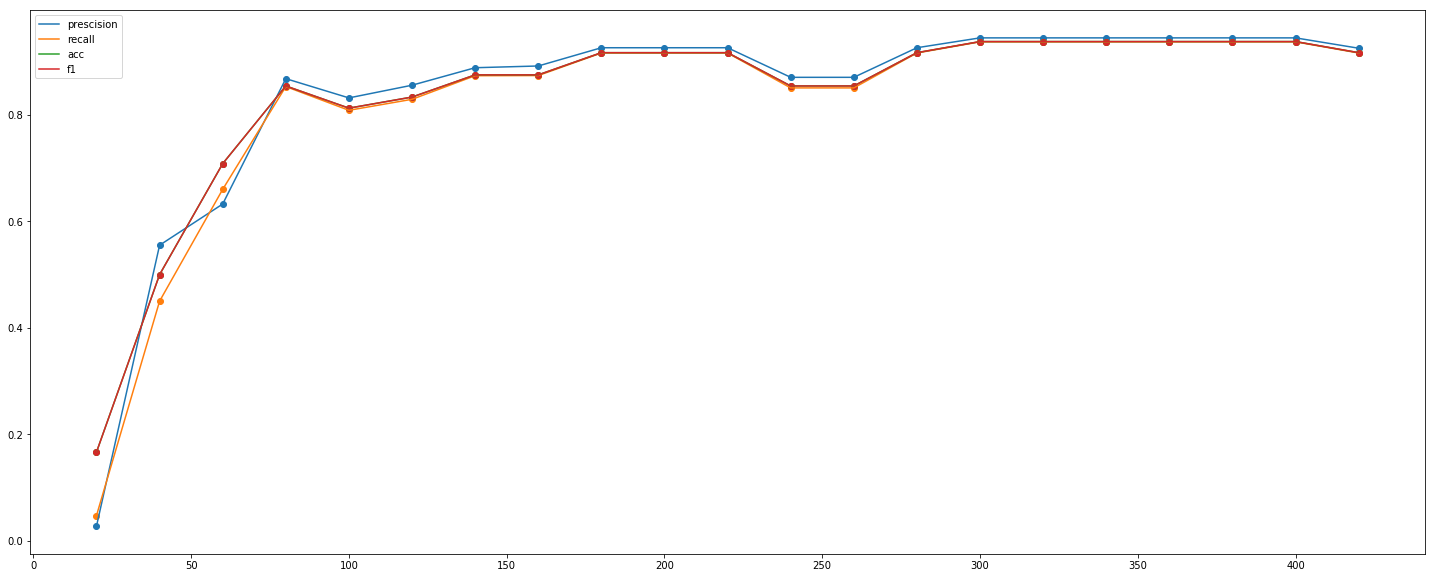

In [0]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [25, 10]
x= range(20,1+int(348*args["num_train_epochs"]/args["train_batch_size"]),args["save_steps"])

plt.plot(x,p,label="prescision")
plt.scatter(x,p)
plt.plot(x,r,label="recall")
plt.scatter(x,r)
plt.plot(x,a,label="acc")
plt.scatter(x,a)
#plt.plot(s,label="spec")
plt.plot(x,f,label="f1")
plt.scatter(x,f)
plt.legend()
plt.show()


In [0]:
!cp ./data/dev.tsv

##Predictions

In [0]:
checkpoints = [args['output_dir']]
if args['eval_all_checkpoints']:
    checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
    logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
logger.info("Evaluate the following checkpoints: %s", checkpoints)
for checkpoint in checkpoints:
    global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
    model = model_class.from_pretrained(checkpoint)
    model.to(device)
    preds = predict(model, tokenizer, prefix=global_step)

In [0]:
!cp ./data_topic/dev.tsv ./data_topic/predict.tsv

In [0]:
checkpoint='outputs_bert/checkpoint-460'
global_step = checkpoint.split('-')[-1]
print(global_step)
model = model_class.from_pretrained(checkpoint)
model.to(device)
preds = predict(model, tokenizer, prefix=global_step)
print(preds)

INFO:pytorch_transformers.modeling_utils:loading configuration file outputs_bert/checkpoint-460/config.json
INFO:pytorch_transformers.modeling_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "multi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 6,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "vocab_size": 50265
}

INFO:pytorch_transformers.modeling_utils:loading weights file outputs_bert/checkpoint-460/pytorch_model.bin


460


INFO:__main__:Creating features from dataset file at data_topic_eval/
100%|██████████| 49/49 [00:00<00:00, 221.13it/s]
INFO:__main__:Saving features into cached file data_topic_eval/cached_predict_roberta-base_364_multi
INFO:__main__:***** Running prediction 460 *****
INFO:__main__:  Num examples = 49
INFO:__main__:  Batch size = 8


[1 1 0 0 0 3 4 2 5 1 0 5 4 2 1 5 2 4 4 3 0 5 2 4 3 2 4 2 3 5 4 2 2 3 3 4 1
 3 3 3 2 5 1 5 0 1 5 4 0]


In [0]:
label_map={0:"Business",1:"Education",2:"Entertainment",3:"Politics",4:"Sports",5:"Technology"}

In [0]:
len(preds)

49

In [0]:
labelled_pred = [label_map[x] for x in preds]

In [0]:
print(labelled_pred)

['Education', 'Education', 'Business', 'Business', 'Business', 'Politics', 'Sports', 'Entertainment', 'Technology', 'Education', 'Business', 'Technology', 'Sports', 'Entertainment', 'Education', 'Technology', 'Entertainment', 'Sports', 'Sports', 'Politics', 'Business', 'Technology', 'Entertainment', 'Sports', 'Politics', 'Entertainment', 'Sports', 'Entertainment', 'Politics', 'Technology', 'Sports', 'Entertainment', 'Entertainment', 'Politics', 'Politics', 'Sports', 'Education', 'Politics', 'Politics', 'Politics', 'Entertainment', 'Technology', 'Education', 'Technology', 'Business', 'Education', 'Technology', 'Sports', 'Business']


In [0]:
!gsutil cp gs://qatar_competition/Submission.csv ./
import pandas as pd
df_sub= pd.read_csv("Submission.csv")

Copying gs://qatar_competition/Submission.csv...
/ [1 files][  904.0 B/  904.0 B]                                                
Operation completed over 1 objects/904.0 B.                                      


In [0]:
df_sub.head()

,File Name,Fake,Domain
0,asd03.blind.txt,NaN,NaN
1,asd01.blind.txt,NaN,NaN
2,qwe02.blind.txt,NaN,NaN
3,poi03.blind.txt,NaN,NaN
4,bsb04.blind.txt,NaN,NaN


In [0]:
df_sub["Domain"]=labelled_pred

In [0]:
df_sub.head()

,File Name,Fake,Domain
0,asd03.blind.txt,NaN,Education
1,asd01.blind.txt,NaN,Education
2,qwe02.blind.txt,NaN,Business
3,poi03.blind.txt,NaN,Business
4,bsb04.blind.txt,NaN,Business


In [0]:
df_sub.to_csv("Submission_with_domain.csv",index=False)

In [0]:
!gsutil cp Submission_with_domain.csv gs://qatar_competition

Copying file://Submission_with_domain.csv [Content-Type=text/csv]...
/ [1 files][  1.3 KiB/  1.3 KiB]                                                
Operation completed over 1 objects/1.3 KiB.                                      


In [0]:
!gsutil -m cp -r ./outputs_bert gs://qatar_competition/outputs_roberta_base_english_topic_fp32_364seqlen/

Copying file://./outputs_bert/checkpoint-280/pytorch_model.bin [Content-Type=application/octet-stream]...
Copying file://./outputs_bert/checkpoint-280/config.json [Content-Type=application/json]...
Copying file://./outputs_bert/eval_results.txt [Content-Type=text/plain]...
Copying file://./outputs_bert/checkpoint-180/pytorch_model.bin [Content-Type=application/octet-stream]...
Copying file://./outputs_bert/checkpoint-240/pytorch_model.bin [Content-Type=application/octet-stream]...
Copying file://./outputs_bert/checkpoint-240/config.json [Content-Type=application/json]...
Copying file://./outputs_bert/checkpoint-180/config.json [Content-Type=application/json]...
Copying file://./outputs_bert/checkpoint-80/pytorch_model.bin [Content-Type=application/octet-stream]...
Copying file://./outputs_bert/checkpoint-80/config.json [Content-Type=application/json]...
Copying file://./outputs_bert/checkpoint-200/pytorch_model.bin [Content-Type=application/octet-stream]...
==> NOTE: You are uploading 

In [0]:
!mv ./data/train.tsv ./data/temp.tsv
!mv ./data/dev.tsv ./data/train.tsv
!mv ./data/temp.tsv ./data/dev.tsv

In [0]:
!gsutil -m cp -r ./outputs_bert gs://qatar_competition/model_roberta_256seqlength

Copying file://./outputs_bert/checkpoint-340/pytorch_model.bin [Content-Type=application/octet-stream]...
Copying file://./outputs_bert/checkpoint-100/config.json [Content-Type=application/json]...
Copying file://./outputs_bert/checkpoint-380/pytorch_model.bin [Content-Type=application/octet-stream]...
Copying file://./outputs_bert/checkpoint-340/config.json [Content-Type=application/json]...
Copying file://./outputs_bert/checkpoint-380/config.json [Content-Type=application/json]...
Copying file://./outputs_bert/checkpoint-320/config.json [Content-Type=application/json]...
Copying file://./outputs_bert/eval_results.txt [Content-Type=text/plain]...
Copying file://./outputs_bert/checkpoint-320/pytorch_model.bin [Content-Type=application/octet-stream]...
Copying file://./outputs_bert/checkpoint-420/pytorch_model.bin [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads